# Part A

# Question 1.
### Calculate the Radon transform of an image and test the back-projection method

#### (a) Load an image of the Shepp-Logan phantom of size 128×128. We will refer to this as ftrue. Show a picture of ftrue. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astra
import scipy
import matplotlib.image as mpimg
import math
from skimage.measure import compare_ssim
from skimage.transform import resize
from functools import partial
#from skimage.metrics import structural_similarity as ssim
from scipy.sparse import spdiags
from scipy.sparse import eye
from scipy.sparse import kron
from scipy.sparse import vstack
from scipy.sparse import hstack
from skimage.measure import compare_psnr
from skimage import filters
import pywt

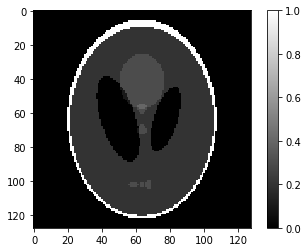

In [2]:
f_true = np.load('SLphan.npy')
plt.imshow(f_true, cmap = 'gray')
plt.colorbar()
plt.savefig('./images_1/SheppLogan.png', bbox_inches='tight')
plt.show()

#### (b) Generate the Radon transform g = Rf of this phantom in 1-degree intervals from 0−179. Display g as a 2D-image; this is referred to as the sinogram of ftrue. What is the size of this sinogram and how is this determined

(180, 130)


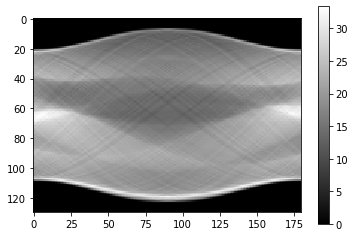

In [237]:
# Create volume geometries 
v,h = f_true.shape 
vol_geom = astra.create_vol_geom(v,h)

# Create projector geometries 
det_count = 130
angles = np.linspace(0,np.pi,180,endpoint=False) 
proj_geom = astra.create_proj_geom('parallel',1.,det_count,angles)

# Create projector 
projector_id = astra.create_projector('strip', proj_geom, vol_geom)

# Radon transform (generate sinogram) 
sinogram_id, sinogram = astra.create_sino(f_true, projector_id)

print(sinogram.shape)

plt.imshow(sinogram.T, cmap='gray')
plt.colorbar()
plt.savefig('./images_1/SheppLogan_sinogram.png', bbox_inches='tight')
plt.show()

#### (c) Compute the unﬁltered back-projection and apply it to the sinogram data you generated. What is the size of the back-projected image?

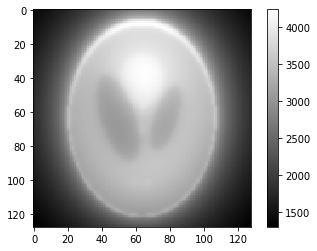

In [238]:
# Create a data object for the reconstruction 
rec_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction via back-projection 
cfg = astra.astra_dict('BP') 
cfg['ReconstructionDataId'] = rec_id 
cfg['ProjectionDataId'] = sinogram_id 
cfg['ProjectorId'] = projector_id

# Create the algorithm object from the configuration structure 
alg_id = astra.algorithm.create(cfg)

# Run back-projection and get the reconstruction 
astra.algorithm.run(alg_id) 
f_rec = astra.data2d.get(rec_id)
plt.imshow(f_rec, cmap='gray')
plt.colorbar()
plt.savefig('./images_1/SheppLogan_backprojection.png',  bbox_inches='tight')
plt.show()
#compare_ssim(f_true, f_rec)

#### (d) Compute the ﬁltered back-projection and apply it to the sinogram data g that you generated. Verify that this gives a good estimate of the inverse of the Radon transform.

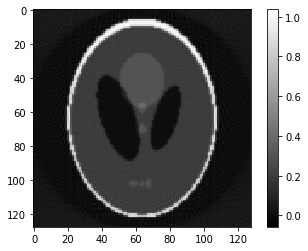

In [239]:
rec_id_2 = astra.data2d.create('-vol', vol_geom)

cfg_2 = astra.astra_dict('FBP_CUDA') 
cfg_2['ReconstructionDataId'] = rec_id_2 
cfg_2['ProjectionDataId'] = sinogram_id 
cfg_2['ProjectorId'] = projector_id

# Create the algorithm object from the configuration structure 
alg_id_2 = astra.algorithm.create(cfg_2)

# Run back-projection and get the reconstruction 
astra.algorithm.run(alg_id_2) 
f_rec_2 = astra.data2d.get(rec_id_2)

plt.imshow(f_rec_2, cmap='gray')
plt.colorbar()
plt.savefig('./images_1/SheppLogan_filtered_backprojection.png', bbox_inches='tight')
plt.show()

In [240]:
compare_ssim(f_true.astype('float32'), f_rec_2)

0.8422654597284611

#### (e) Add noise to the data g and test how the error in your reconstruction grows with the scale of the measurement noise.

In [45]:
# Creater placeholder volume for noisy reconstructions
rec_id_noise = astra.data2d.create('-vol', vol_geom)

In [46]:
def get_recon_noise(sigma):
    
    # Add noise to sinogram
    #sino_with_noise = astra.functions.add_noise_to_sino(sinogram, sigma, seed=None)
    sino_with_noise = sinogram + np.random.normal(0, sigma, sinogram.shape)
    # Store sinogram data to sinogram_id object
    astra.data2d.store(sinogram_id, sino_with_noise)
    
    # Change reconstruction placeholder in configuration structure
    cfg_2['ReconstructionDataId'] = rec_id_noise
    
    alg_id = astra.algorithm.create(cfg_2)

    # Run back-projection and get the reconstruction 
    astra.algorithm.run(alg_id) 
    f_rec_noise = astra.data2d.get(rec_id_noise)
    
    astra.algorithm.delete(alg_id)
    
    return sino_with_noise, f_rec_noise

In [47]:
sigmas = np.linspace(0, 6, 100)
ssims = np.zeros(sigmas.size)
mses = np.zeros(sigmas.size)
for i, s in enumerate(sigmas):
    ssims[i] = compare_ssim(f_true.astype('float32'), get_recon_noise(s)[1], full=True)[0]
    mses[i] = np.linalg.norm(f_true.astype('float32') - get_recon_noise(s)[1])

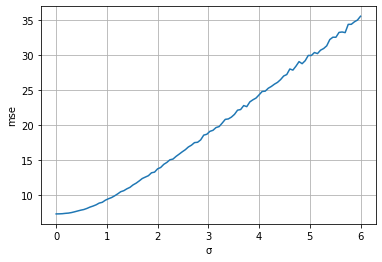

In [21]:
plt.plot(sigmas, mses)
plt.grid()
plt.xlabel('\u03C3')
plt.ylabel('mse')
#plt.title('noise level vs reconstruction error')
plt.savefig('./images_1/noise_against_ssim.png')
plt.show()

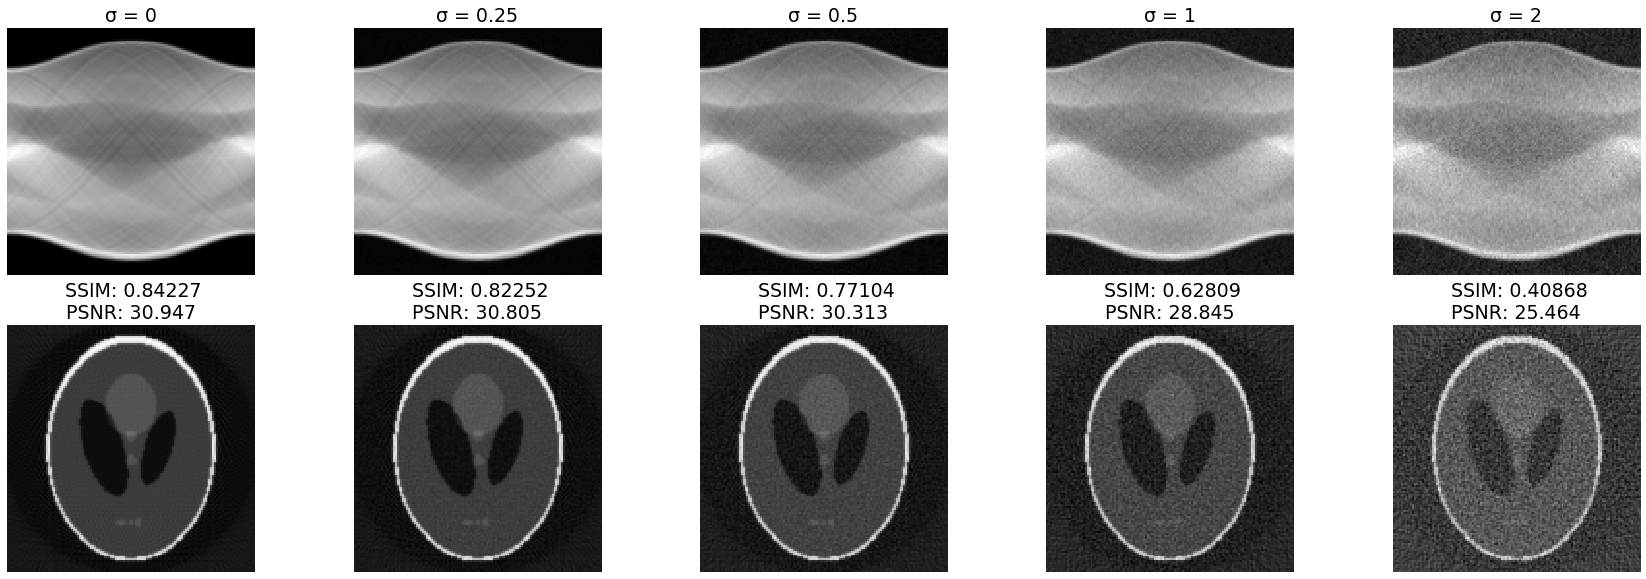

In [60]:
fig, ax = plt.subplots(2, 5, figsize=(30,10))
[axi.set_axis_off() for axi in ax.ravel()]
for i, s in enumerate([0, 0.25, 0.5, 1, 2]):
    
    sino_with_noise, f_rec = get_recon_noise(s)
    sino_with_noise = resize(sino_with_noise, f_rec.shape)
    ax[0,i].set_title('\u03C3 = {}'.format(s), fontsize=19)
    ax[0,i].imshow(sino_with_noise.T, cmap='gray')
    ax[1,i].imshow(f_rec, cmap='gray')
    ax[1,i].set_title('  SSIM: {0:.5g} \nPSNR: {1:.5g}'.format(compare_ssim(f_true, f_rec), compare_psnr(f_true, f_rec)), fontsize=19)
    
plt.savefig('./images_1/noise_against_ssim_examples.png', bbox_inches='tight')
plt.show()

# Question 2.
### Calculate an explicit matrix form of the Radon transform and investigate its SVD.

#### (a) Create a zero matrix A with number of rows equal to the number of angles x number of projection samples, and with number of columns equal to the number of pixels in the image.

In [22]:
# test image
f = np.zeros((64, 64))
num_pixels = f.size

#### (b) Go through a loop for the number of pixels in the image (in column-major). For each pixel j in the loop create an image of the same size with a 1 in that pixel and zero everywhere else. Take the Radon transform of this image and reshape the result into a column vector. This forms the jth column of the matrix A.

In [23]:
mat = np.zeros(f.shape)

In [24]:
# Create volume geometries 
v,h = mat.shape 
vol_geom = astra.create_vol_geom(v,h)

In [25]:
def find_spectrum(number_of_projections, angle_range, number_of_samples):
    
    angles = np.linspace(0, angle_range, number_of_projections, endpoint=False)
    
    A = np.zeros((angles.size*number_of_samples, num_pixels))

    # Create projector geometries 
    proj_geom = astra.create_proj_geom('parallel',1.,number_of_samples,angles)

    # Create projector 
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)
    
    col = 0
    for i in range(f.shape[1]):
        for j in range(f.shape[0]):

            # place single pixel in matrix
            mat[j, i] = 1

            # Radon transform - create sinogram
            sinogram_id, sinogram = astra.create_sino(mat, projector_id)

            # Form jth column of A
            A[:,col] = np.reshape(sinogram, -1)

            # Reset data
            astra.data2d.clear()
            mat[j, i] = 0

            col += 1
            
    astra.projector.clear()
            
    return A
    

In [26]:
from skimage.transform import resize
f_true = np.load('SLphan.npy')
f_true = resize(f_true, f.shape)

number_of_angles = 45
angle_range = np.pi
number_of_projections = 95

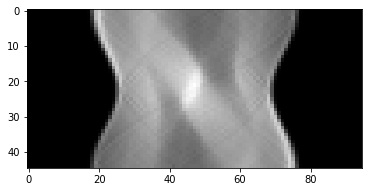

In [27]:
A = find_spectrum(number_of_angles, angle_range, number_of_projections)
plt.imshow((A @ f_true.flatten()).reshape(number_of_angles, number_of_projections), cmap='gray')
plt.show()

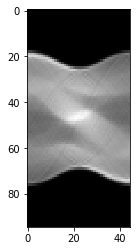

In [28]:
plt.imshow((A @ f_true.flatten()).reshape(number_of_angles, number_of_projections).T, cmap='gray')
plt.savefig('./images_1/matrix_sino', bbox_inches='tight')
plt.show()

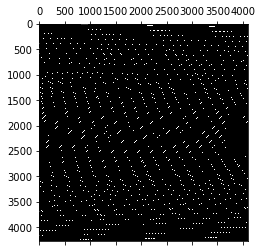

In [33]:
plt.spy(A, cmap='gray', origin='upper')
plt.savefig('./images_1/A_matrix', bbox_inches='tight')
plt.show()

In [292]:
95*45

4275

In [302]:
A_list = []
proj_list = np.linspace(10, 90, 9).astype(int)
proj_list = [10, 30, 50, 70, 90]
angle_range = np.pi
number_of_samples = 90

In [303]:
for proj in proj_list:
    A = find_spectrum(proj, angle_range, number_of_samples)
    A_list.append(A)

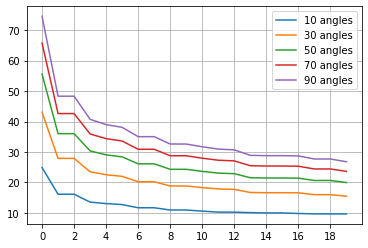

In [304]:
for c, A in enumerate(A_list):
    _, W, _ = scipy.sparse.linalg.svds(A, k=20)
    plt.plot(np.flip(W), label='{} angles'.format(proj_list[c]))
plt.legend()
plt.grid()
plt.xticks(np.arange(0, 20, 2))
plt.savefig('./images_1/svd_num_proj.png', bbox_inches='tight')

In [58]:
A.shape

(1800, 4096)

In [22]:
A_list_2 = []
angle_list = np.linspace(np.pi/5, np.pi, 5)
number_of_projections = 90

In [23]:
for angle_range in angle_list:
    A = find_spectrum(number_of_projections, angle_range, number_of_samples)
    A_list_2.append(A)

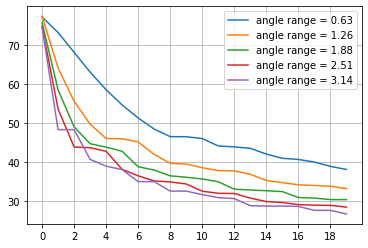

In [26]:
for c, A in enumerate(A_list_2):
    _, W, _ = scipy.sparse.linalg.svds(A, k=20)
    plt.plot(np.flip(W), label='angle range = {0:.2f}'.format(angle_list[c]))
plt.legend()
plt.grid()
plt.xticks(np.arange(0, 20, 2))
plt.savefig('./images_1/svd_angle_range.png', bbox_inches='tight')

# Question 3. 
### Implement a matrix-free regularised least-squares solver for the Radon Transform.

### Class to do most of what we want - 
Inputs:
* range of angles, number of angles, detector count 
* noise level,
* Tikhonov regularisation type

Methods:
* find optimal alpha regularisation parameter
* perform zero-order or first order backprojection
* perform filtered backprojection 


In [2]:
class Xray():
    
    def __init__(self, f, angle_range, num_proj, det_count, sigma, reg_type):
        
        # Defining Geometry and Projection properties
        self._v, self._h = f.shape
        self._vol_geom = astra.create_vol_geom(self._v, self._h)
        self._angles = np.linspace(0, angle_range, num_proj, endpoint=False)
        self._proj_geom = astra.create_proj_geom('parallel', 1., det_count, self._angles)
        self._proj_id = astra.create_projector('strip', self._proj_geom, self._vol_geom)
        self._proj_size = np.prod(astra.geom_size(self._proj_geom))
        self._vol_size = np.prod(astra.geom_size(self._vol_geom))
        self._sigma = sigma
        self._alpha = 10
        # Operator to perform easy projection
        self._W = astra.OpTomo(self._proj_id)
        
        # Initialise sinogram
        self._sinogram_id, self._sinogram = astra.create_sino(f, self._proj_id)
        self._sinogram += np.random.normal(0, self._sigma, self._sinogram.shape)
        astra.data2d.store(self._sinogram_id,  self._sinogram)
        # Regularisation constant
        self._tol = 1e-3
        
        if(reg_type == 'zero'):
            self._reg_type = 0
        else:
            self._reg_type = 1
            self.form_gradient_operator()
        
        # Backprojected image
        self._bp = None
        
        # Filtered backprojection parameters
        self._rec_id = astra.data2d.create('-vol', self._vol_geom)
        self._cfg = astra.astra_dict('FBP') 
        self._cfg['ReconstructionDataId'] = self._rec_id
        self._cfg['ProjectionDataId'] = self._sinogram_id 
        self._cfg['ProjectorId'] = self._proj_id

        # Create the algorithm object from the configuration structure 
        self._alg_id = astra.algorithm.create(self._cfg)
    
    # LSQR forward projection (zero order)
    def A(self, x, alpha):
        return np.hstack((self._W*x, np.sqrt(alpha)*x.ravel()))
    
    # LSQR forward projection (first order)
    def Af(self, x, alpha):
        z = (self._W*x)
        #y = np.sqrt(alpha)*(self._grad_op @ x.ravel())
        y1 = filters.sobel_h(x.reshape(self._v, self._h)).ravel()
        y2 = filters.sobel_v(x.reshape(self._v, self._h)).ravel()
        return np.hstack((z, np.sqrt(alpha)*y1, np.sqrt(alpha)*y2))
    
    # LSQR back projection
    def AT(self, y):
        return self._W.T*y[:self._proj_size]
    
    # Zero-Order Tikhonov Backprojection
    def tikZBP(self, alpha):
        M = scipy.sparse.linalg.LinearOperator((self._proj_size + self._vol_size, self._vol_size), 
                                               matvec = partial(self.A, alpha = alpha),
                                                rmatvec = partial(self.AT))
        output = scipy.sparse.linalg.lsqr(M, np.hstack((self._sinogram.ravel(), np.zeros(self._vol_size))), 
                                          atol = self._tol, btol = self._tol)
        return output[0]
    
    # First-Order Tikhonov Backprojection
    def tik1BP(self, alpha):
        M = scipy.sparse.linalg.LinearOperator((self._proj_size + 2*self._vol_size, self._vol_size), 
                                               matvec = partial(self.Af, alpha = alpha),
                                                rmatvec = partial(self.AT))
        output = scipy.sparse.linalg.lsqr(M, np.hstack((self._sinogram.ravel(), np.zeros(2*self._vol_size))), 
                                          atol = self._tol, btol = self._tol)
        return output[0]

    def form_gradient_operator(self):
        x = np.vstack((-np.ones((self._v)), np.ones((self._v))))
        D1 = scipy.sparse.lil_matrix((spdiags(x, [0, 1], self._v, self._v)))
        D1[-1,:] = 0
        D1y2d = kron(D1, eye(self._v))
        D1x2d = kron(eye(self._v), D1)
        self._grad_op = vstack((D1x2d, D1y2d))
        pass
    
    # Discrepancy principle function
    def DP(self, alpha, reg_func):
        f_alpha = reg_func(alpha) 
        r_alpha = (1/self._proj_size)*np.linalg.norm(self._sinogram.ravel() - 
                                                     (self._W*f_alpha).ravel())**2 - self._sigma**2
        return r_alpha
    
    # Find optimal alpha
    def find_optimal_alpha(self, initial_guess):
        if(self._reg_type == 0):
            self._alpha = (scipy.optimize.root(partial(self.DP, reg_func = self.tikZBP) , initial_guess).x)[0]
        else:
            self._alpha = (scipy.optimize.root(partial(self.DP, reg_func = self.tik1BP) , initial_guess).x)[0]
            
        return self._alpha
    
    # Get the backprojection with given alpha value
    def get_bp(self, alpha):
        if(self._reg_type == 0):
            self._bp = self.tikZBP(alpha)
        else:
            self._bp = self.tik1BP(alpha)
        
        return self._bp.reshape((self._v, self._h))
    
    # Run back-projection and get the reconstruction
    def get_fbp(self): 
        astra.algorithm.run(self._alg_id) 
        f_rec = astra.data2d.get(self._rec_id)
        return(f_rec.reshape((self._v, self._h)))
    
    def getA(self):
        return self._W
    
    def getG(self):
        return self._sinogram
    
    def get_A_matrix(self):
        
        A = np.zeros((self._proj_size, self._vol_size))
        mat = np.zeros((self._v,self._h))
        col = 0
        for i in range(self._h):
            for j in range(self._v):

                # place single pixel in matrix
                mat[j, i] = 1

                # Radon transform - create sinogram
                sinogram = self._W*mat

                # Form jth column of A
                A[:,col] = np.reshape(sinogram, -1)
                
                # Reset mat
                mat[j, i] = 0

                col += 1

        return A

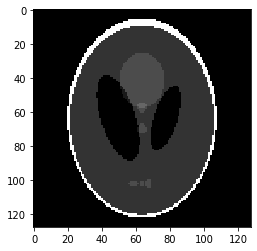

In [53]:
# Import and display data-generating image f_true
f_true = np.load('SLphan.npy')
plt.imshow(f_true, cmap='gray')
plt.show()

In [54]:
sigma = 0.5
det_count = 130

### Full Range, limited number of angles

In [55]:
# Define X-rays for limited number of angles - 30, 45, and 60 total samples.
angle_count = [30, 45, 60]
xrays_lna_0 = []
xrays_lna_1 = []
for number in angle_count:
    xrays_lna_0.append(Xray(f_true, np.pi, number, det_count, sigma, 'zero'))
    xrays_lna_1.append(Xray(f_true, np.pi, number, det_count, sigma, 'first'))

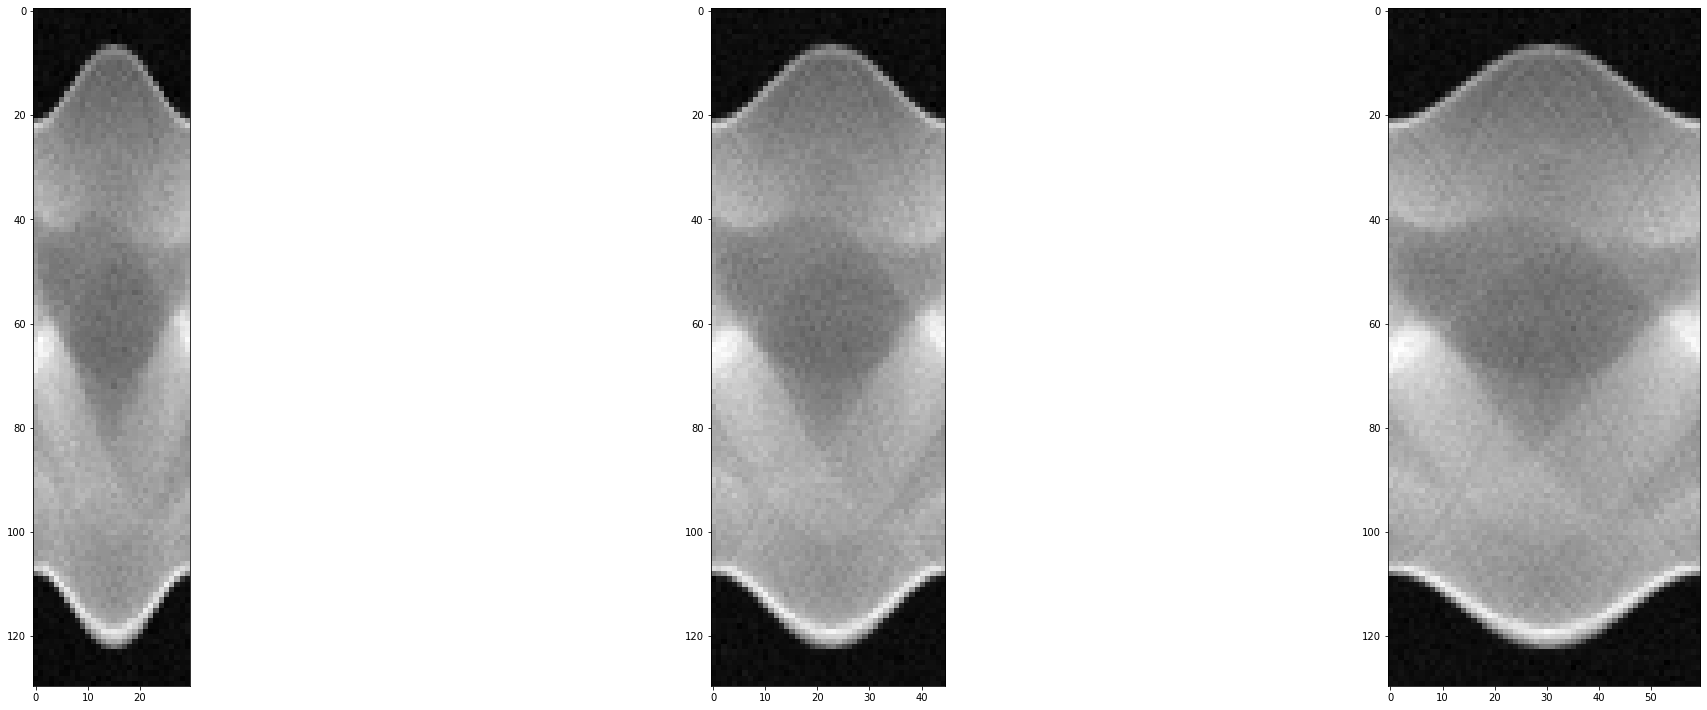

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
fig.tight_layout()
for i in range(3):
    ax[i].imshow(xrays_lna_0[i]._sinogram.T, cmap='gray')
plt.show()

### Zero-Order and First-Order Tikhonov

In [57]:
alphas_lna = []
zero_bp_lna = []
fbp_lna = []
alphas_lna_1 = []
zero_bp_lna_1 = []

for i in range(3):
    
    print('0-order, xray {}'.format(i))
    # zero-order
    alphas_lna.append(xrays_lna_0[i].find_optimal_alpha(initial_guess = 10))
    zero_bp_lna.append(xrays_lna_0[i].get_bp(xrays_lna_0[i]._alpha))
    
    print('1-order, xray {}'.format(i))
    # first-order
    alphas_lna_1.append(xrays_lna_1[i].find_optimal_alpha(initial_guess = 10))
    zero_bp_lna_1.append(xrays_lna_1[i].get_bp(xrays_lna_1[i]._alpha))
    
    # filtered backprojection
    fbp_lna.append(xrays_lna_0[i].get_fbp())

0-order, xray 0
1-order, xray 0
0-order, xray 1
1-order, xray 1
0-order, xray 2
1-order, xray 2


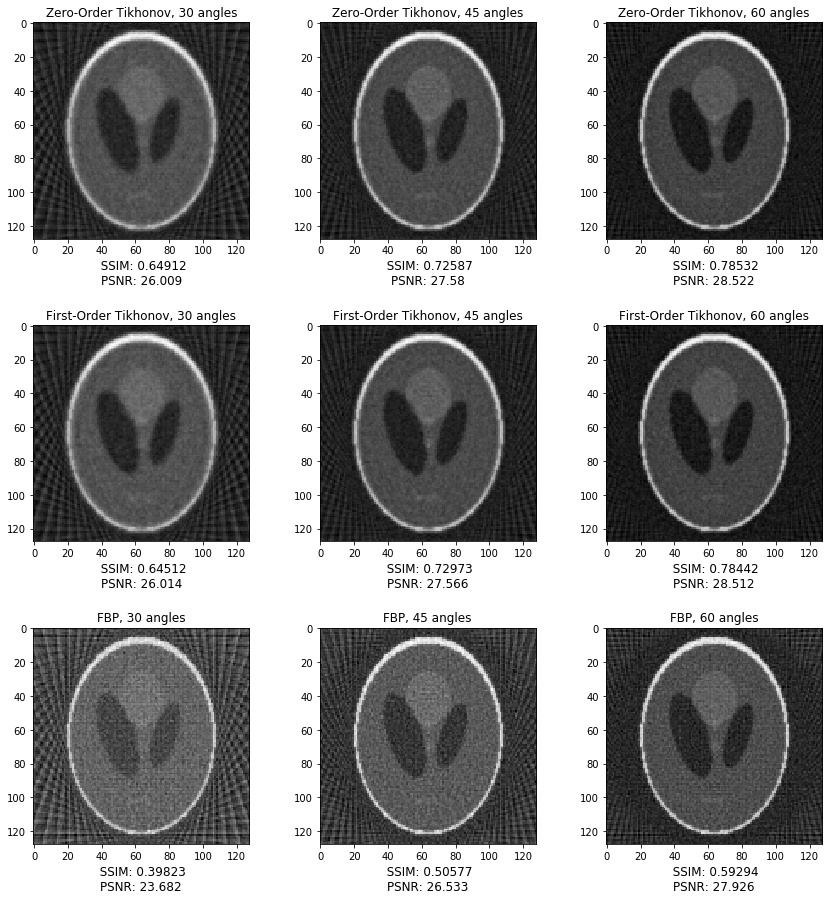

In [61]:
fig, ax = plt.subplots(3, 3, figsize=(12,12))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
for i in range(3):

    ax[0, i].imshow(zero_bp_lna[i], cmap='gray')
    ax[0, i].set_xlabel('  SSIM: {0:.5g} \nPSNR: {1:.5g}'.format(compare_ssim(f_true, zero_bp_lna[i].astype('float64')), compare_psnr(f_true, zero_bp_lna[i].astype('float64'))), fontsize=12)
    ax[0, i].set_title('Zero-Order Tikhonov, {} angles'.format(angle_count[i]))
    
    ax[1, i].imshow(zero_bp_lna_1[i], cmap='gray')
    ax[1, i].set_xlabel('  SSIM: {0:.5g} \nPSNR: {1:.5g}'.format(compare_ssim(f_true, zero_bp_lna_1[i].astype('float64')), compare_psnr(f_true, zero_bp_lna_1[i].astype('float64'))), fontsize=12)
    ax[1, i].set_title('First-Order Tikhonov, {} angles'.format(angle_count[i]))
    
    ax[2, i].imshow(fbp_lna[i], cmap='gray')
    ax[2, i].set_xlabel('  SSIM: {0:.5g} \nPSNR: {1:.5g}'.format(compare_ssim(f_true, fbp_lna[i].astype('float64')), compare_psnr(f_true, fbp_lna[i].astype('float64'))), fontsize=12)
    ax[2, i].set_title('FBP, {} angles'.format(angle_count[i]))
plt.savefig('./images_1/tik_lim_angle', bbox_inches='tight')
plt.show()

In [62]:
astra.data2d.clear()
astra.projector.clear()
astra.algorithm.clear()

### Limited range


In [63]:
sigma = 0.5
det_count = 130

In [64]:
angle_range = [np.pi/2, 3*np.pi/4, np.pi]
xrays_lr_0 = []
xrays_lr_1 = []
for r in angle_range:
    xrays_lr_0.append(Xray(f_true, r, 90, det_count, sigma, 'zero'))
    xrays_lr_1.append(Xray(f_true, r, 90, det_count, sigma, 'first'))

In [65]:
alphas_lr_0 = []
bp_lr_0 = []
alphas_lr_1 = []
bp_lr_1 = []
fbp_lr = []

for i in range(3):
    
    print('0-order, xray {}'.format(i+1))
    # zero-order
    alphas_lr_0.append(xrays_lr_0[i].find_optimal_alpha(initial_guess = 10))
    bp_lr_0.append(xrays_lr_0[i].get_bp(xrays_lr_0[i]._alpha))
    
    print('1-order, xray {}'.format(i+1))
    # first-order
    alphas_lr_1.append(xrays_lr_1[i].find_optimal_alpha(initial_guess = 10))
    bp_lr_1.append(xrays_lr_1[i].get_bp(xrays_lr_1[i]._alpha))
    
    # filtered backprojection
    fbp_lr.append(xrays_lr_0[i].get_fbp())

0-order, xray 1
1-order, xray 1
0-order, xray 2
1-order, xray 2
0-order, xray 3
1-order, xray 3


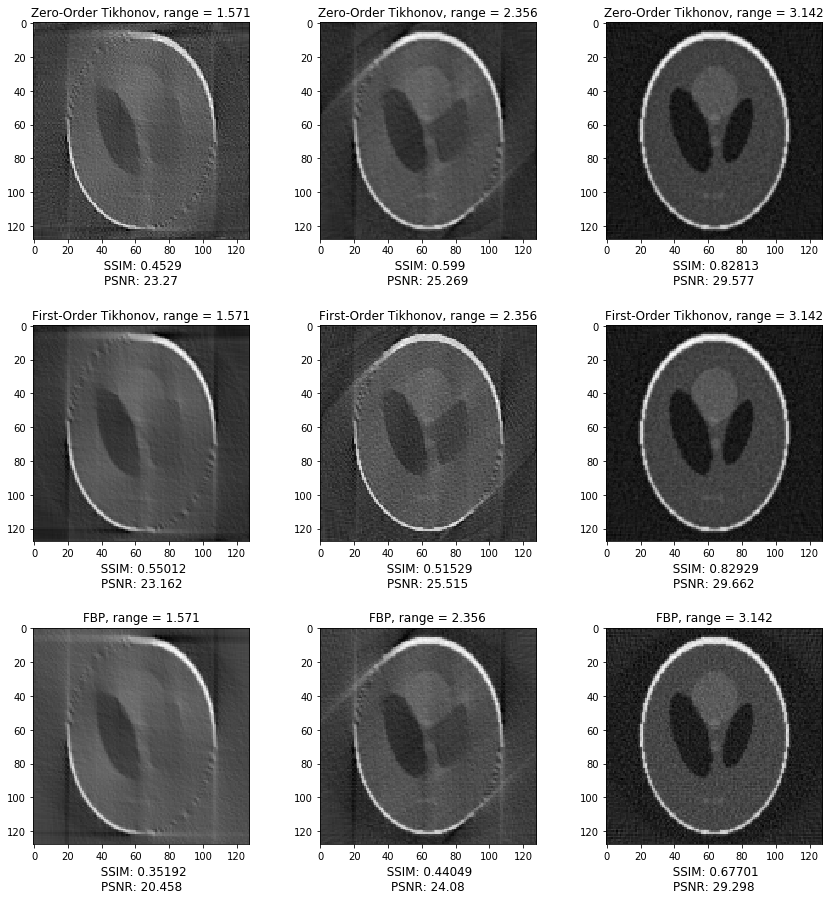

In [66]:
fig, ax = plt.subplots(3, 3, figsize=(12,12))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
for i in range(3):

    ax[0, i].imshow(bp_lr_0[i], cmap='gray')
    ax[0, i].set_xlabel('  SSIM: {0:.5g} \nPSNR: {1:.5g}'.format(compare_ssim(f_true, bp_lr_0[i].astype('float64')), compare_psnr(f_true, bp_lr_0[i].astype('float64'))), fontsize=12)
    ax[0, i].set_title('Zero-Order Tikhonov, range = {0:.4g}'.format(angle_range[i]))
    
    ax[1, i].imshow(bp_lr_1[i], cmap='gray')
    ax[1, i].set_xlabel('  SSIM: {0:.5g} \nPSNR: {1:.5g}'.format(compare_ssim(f_true, bp_lr_1[i].astype('float64')), compare_psnr(f_true, bp_lr_1[i].astype('float64'))), fontsize=12)
    ax[1, i].set_title('First-Order Tikhonov, range = {0:.4g}'.format(angle_range[i]))
    
    ax[2, i].imshow(fbp_lr[i], cmap='gray')
    ax[2, i].set_xlabel('  SSIM: {0:.5g} \nPSNR: {1:.5g}'.format(compare_ssim(f_true, fbp_lr[i].astype('float64')), compare_psnr(f_true, fbp_lr[i].astype('float64'))), fontsize=12)
    ax[2, i].set_title('FBP, range = {0:.4g}'.format(angle_range[i]))

plt.savefig('./images_1/tik_lim_range', bbox_inches='tight')
plt.show()

In [67]:
astra.data2d.clear()
astra.projector.clear()
astra.algorithm.clear()

# Question 4.
### Write a Haar wavelet denoiser.

#### Take any (monochrome) image of your choice. Calculate the Haar wavelet transform of this image. Plot some of the coefficients and explain what you see.

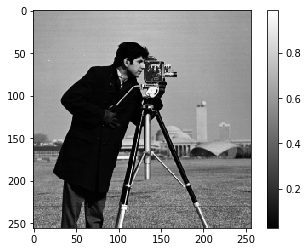

In [68]:
f = mpimg.imread('./images_1/images_4/Cameraman256.png')
plt.imshow(f, cmap='gray')
plt.colorbar()
plt.savefig('./images_1/Cameraman256.png', bbox_inches='tight')
plt.show()

In [69]:
level = int(math.floor(np.log2(f.shape[0])))
coeffs_plot = pywt.wavedec2(f,'haar',level = 3)
coeffs = pywt.wavedec2(f,'haar',level = level)

[]

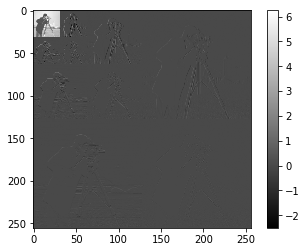

In [70]:
arr, coeff_slices = pywt.coeffs_to_array(coeffs_plot)
#plt.figure(figsize=(20,20))
plt.imshow(arr, cmap='gray')
plt.colorbar()
plt.savefig('./images_1/haar_coeff.png', bbox_inches='tight')
plt.plot()

#### Plotting of the Haar wavelet coefficients for 2 levels. What do you see?
Each level corresponds to the Haar transform coefficients at different scales. The first level (top left) are the coefficients of the Haar wavelet at the maximum scale i.e. in the formula
\begin{equation}
\psi_{m,n}(x) = 2^{-\frac{m}{2}}\psi^{\text{mother}}(2^{-m}x-n)
\end{equation}
we have $m=3$
https://mil.ufl.edu/nechyba/www/eel6562/course_materials/t5.wavelets/intro_dwt.pdf

#### Reconstruct the image from the coeffcients by calling the inverse wavelet transform. Check if your reconstructed image coincides with the original.

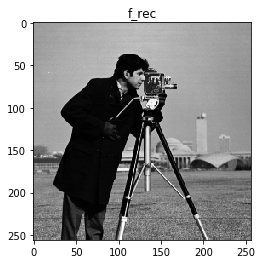

Difference between image and its reconstruction = 5.6610363e-05


In [71]:
f_rec = pywt.waverec2(coeffs,'haar')
plt.imshow(f_rec, cmap='gray')
plt.title('f_rec')
plt.show()
print('Difference between image and its reconstruction =', np.linalg.norm(f_rec - f))

#### Write a function that implements thresholding for a given range (the different scales of your wavelet coeffcients) and threshold parameter, and form a modified image by performing the inverse wavelet transform on the thresholded coeffcients.

In [72]:
def thresholdFunction(coeffs,tRange,tVal):
    coeffsT = []
    coeffsT.append(coeffs[0])
    # loop over all coefficients
    for i in range(1, len(coeffs)):
        # threshold coefficients in the selected levels
        if i in tRange:
            lcoeffs = [pywt.threshold(key, value=tVal, mode='soft') for key in coeffs[i]]
            coeffsT.append(lcoeffs)
        # append all coefficients otherwise
        else:
            lcoeffs = [key for key in coeffs[i]]
            coeffsT.append(lcoeffs)
    return coeffsT

#### Create a noisy version of your original image and perform denoising by thresholding of the wavelet coefficients. Investigate the effect of changing the range and the threshold parameter.

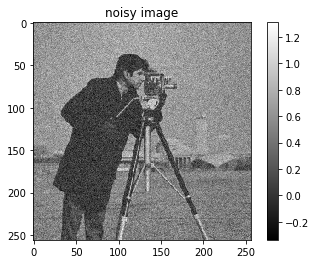

In [73]:
# Create noisy image
sigma = 0.1
f_noise = f + np.random.normal(0, sigma, f.shape)
plt.imshow(f_noise, cmap='gray')
plt.title('noisy image')
plt.colorbar()
plt.show()

In [74]:
def denoise(data, tRange, tVal, level):
    """
    Denoise an image by taking the Haar wavelet transform, thresholding 
    the coefficients then applying the inverse transform.
    Input:
        - data: input image
        - tRange: scales to threshold over
        - tVal: threshold value
        - level: max scale/level of transform.
    """
    # Apply Haar wavelet transform
    coeffs = pywt.wavedec2(data,'haar',level = level)
    # Threshold coefficients
    coeffsT = thresholdFunction(coeffs, tRange, tVal)
    # Apply inverse transform on thresholded coefficients
    denoised = pywt.waverec2(coeffsT,'haar')
    
    return denoised

In [75]:
def est_thresh(f, x, level):
    """
    Function to estimate the threshold value for a given percentile cut off.
    """
    tc = pywt.wavedec2(f,'haar', level)
    arr, coeff_slices = pywt.coeffs_to_array(tc)
    arr = np.sort(abs(arr.flatten()))
    tVal =  arr[int(arr.size*x)]
    return tVal

In [76]:
percent = 0.9
tVal = est_thresh(f_noise, percent, level=8, )
print('Threshold Value estimate: {0:.05g}'.format(tVal))

Threshold Value estimate: 0.19891


In [77]:
maxRange = level+1;

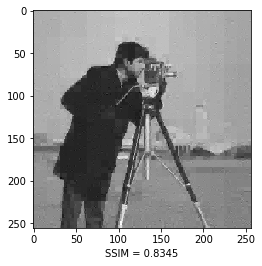

In [78]:
# Denoising via full range and 90th percentile threshold estimate
range_full = range(maxRange);
f_rec_full = denoise(f_noise, range_full, tVal, level)
plt.imshow(f_rec_full, cmap='gray')
plt.xlabel('SSIM = {0:.05g}'.format(compare_ssim(f, f_rec_full.astype('float32'))))
plt.show()

#### Exploring the effect of changing range

In [79]:
range_hf = range(0, maxRange)
range_lf = range(0, maxRange-1)
range_opt = range(5, maxRange)
f_rec_hf = denoise(f_noise, range_hf, tVal, level=8)
f_rec_lf = denoise(f_noise, range_lf, tVal, level=8)
f_rec_op = denoise(f_noise, range_opt, tVal, level=8)

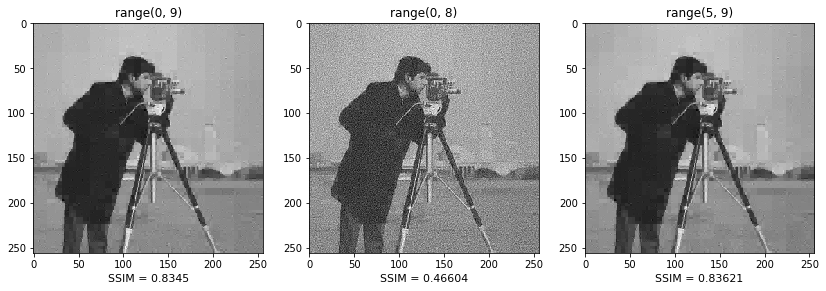

In [80]:
fig, axes = plt.subplots(figsize = (14, 10), nrows=1, ncols=3)

axes[0].imshow(f_rec_hf, cmap='gray')
axes[0].set_xlabel('SSIM = {0:.05g}'.format(compare_ssim(f, f_rec_hf.astype('float32'))), fontsize=11)
axes[0].set_title('{}'.format(range_hf))

axes[1].imshow(f_rec_lf, cmap='gray')
axes[1].set_xlabel('SSIM = {0:.05g}'.format(compare_ssim(f, f_rec_lf.astype('float32'))), fontsize=11)
axes[1].set_title('{}'.format(range_lf))

axes[2].imshow(f_rec_op, cmap='gray')
axes[2].set_xlabel('SSIM = {0:.05g}'.format(compare_ssim(f, f_rec_op.astype('float32'))),fontsize=11)
axes[2].set_title('{}'.format(range_opt))

plt.savefig('./images_1/haar_lim_range', bbox_inches='tight')
plt.show()

- LHS - full range given for comparison.
- MID - discarding lowest scale (high frequency) coefficients results in very poor results. This is to be expected since the noise occupies these high frequencies.
- RHS - conversely, discarding the high scale (low frequency) coefficients in the range (0,4) produces a denoising that is very similar to the denoised image with full range.

#### Exploring the effect of changing threshold

In [81]:
arr, coeff_slices = pywt.coeffs_to_array(coeffs)

In [82]:
tVal_l = est_thresh(f_noise, 0.7, level)
tVal_h = est_thresh(f_noise, 0.95, level)

f_rec_hf = denoise(f_noise, range_hf, tVal_l, level)
f_rec_lf = denoise(f_noise, range_hf, tVal, level)
f_rec_op = denoise(f_noise, range_hf, tVal_h, level)

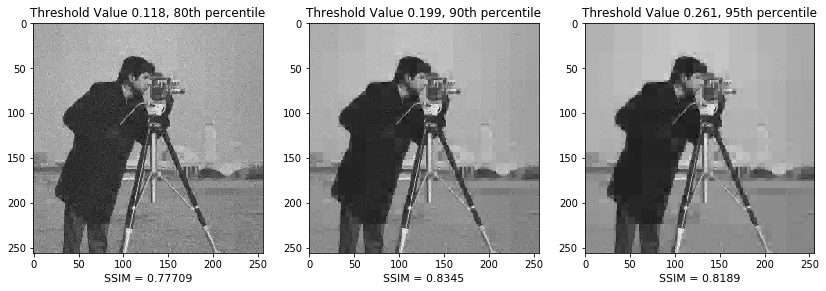

In [83]:
fig, axes = plt.subplots(figsize = (14, 10), nrows=1, ncols=3)

axes[0].imshow(f_rec_hf, cmap='gray')
axes[0].set_xlabel('SSIM = {0:.05g}'.format(compare_ssim(f, f_rec_hf.astype('float32'))), fontsize=11)
axes[0].set_title('Threshold Value {0:.03f}, 80th percentile'.format(tVal_l))

axes[1].imshow(f_rec_lf, cmap='gray')
axes[1].set_xlabel('SSIM = {0:.05g}'.format(compare_ssim(f, f_rec_lf.astype('float32'))), fontsize=11)
axes[1].set_title('Threshold Value {0:.03f}, 90th percentile'.format(tVal))

axes[2].imshow(f_rec_op, cmap='gray')
axes[2].set_xlabel('SSIM = {0:.05g}'.format(compare_ssim(f, f_rec_op.astype('float32'))), fontsize=11)
axes[2].set_title('Threshold Value {0:.03f}, 95th percentile'.format(tVal_h))

plt.savefig('./images_1/haar_lim_thresh', bbox_inches='tight')
plt.show()

- LHS - TV too low, resulting in many high frequencies remaining.
- MID - TV found by taking 90th percentile of coefficients, seems to give nice balance between filtering noise and minimising blocky texture.
- RHS - TV found by 95th percentile seems to be over smoothing.

# Question 5.
###  Iterative soft-thresholding for X-ray tomography.

http://pmelchior.net/blog/the-magic-of-proximal-operators.html
https://math.stackexchange.com/questions/2565332/composition-of-proximal-operators

In [233]:
def ISTA(Xray, alpha, mlambda, maxIter, tol):
    """
    Function to perform the iterative soft thresholding algorithm for reconstructing a sinogram
    Inputs:
        - Xray: xray object that contains the data (sinogram), specification of the forward 
                operator A, etc..
        - alpha: regularisation parameter
        - mlambda: gradient descent rate parameter
        - max_iter: max iterations to perform
        - tol: sufficient decrease level
    Outputs:
        - recon_hist: the reconstruction history (f_k)
    """
    # Get X-ray forward projection operator and image dimesions
    A = Xray.getA()
    v,h = Xray._v, Xray._h
    
    # Get X-ray sinogram
    g = Xray.getG()
    
    # Use max level for Haar Wavelet transform
    level = int(math.floor(np.log2(v)))
    tRange = range(level+1)
    tVal = alpha*mlambda
    
    # Initial guess f0 is simply the filtered backprojection
    f_0 = Xray.get_fbp()
    f_k = f_0
    fks = [f_k]
    
    # Tolerance level and iteration number params
    curTol = tol+1
    numIter = 0
    
    normresold = np.inf

    while((numIter < maxIter) and (curTol > tol)):
        
        f_k_1 = f_k
        # Calculcate gradient descent term
        gd_term = (f_k.ravel() - mlambda*A.T*(A*f_k.ravel() - g.ravel())).reshape((v, h))
        
        # Perform soft thresholding mu = alpha*lambda
        f_k = denoise(gd_term, tRange, tVal, level)
        
        # Non-negativity constraint
        f_k = f_k.clip(min=0)
        fks.append(f_k)
        
        g_rec = A*f_k
        
        curTol = np.linalg.norm(f_k.ravel() - f_k_1.ravel())
        
        print(curTol)
        res = np.linalg.norm(g.flatten() - A*f_k)
            
        numIter += 1
        
    return f_k, fks

#### Varying noise level

In [85]:
xrays_noise = []
sigma_range = [0.0, 0.2, 0.5, 1, 2]
recon_noise = []
for sigma in sigma_range:
    xray = Xray(f_true, angle_range=np.pi, num_proj=90,det_count=130, sigma=sigma, reg_type = 'zero')
    recon_noise.append(ISTA(xray, alpha=1, mlambda=10**-3.8, maxIter = 600, tol=0.01))

1.7067758
0.46245852
0.31936383
0.24160852
0.19768733
0.16579388
0.14309962
0.12559722
0.112511925
0.101507984
0.09257174
0.08526533
0.079343736
0.074156374
0.06974687
0.06593299
0.06258873
0.059667148
0.056987815
0.05465761
0.052587193
0.05068929
0.04902893
0.047494568
0.04611336
0.044866923
0.043647744
0.042562615
0.041539073
0.040599477
0.03971887
0.038875878
0.038051628
0.037305422
0.036601443
0.035914395
0.035285767
0.034700766
0.034120023
0.0335389
0.03301344
0.032506526
0.032012176
0.031555545
0.031107757
0.030678503
0.030269524
0.029865257
0.029479537
0.029094068
0.028729234
0.028372359
0.028025413
0.027691264
0.027377116
0.02705597
0.026748005
0.026453007
0.02617419
0.025898252
0.025624659
0.025350625
0.02508921
0.02483297
0.024572384
0.024330406
0.024092382
0.023836141
0.023601333
0.02336686
0.023150718
0.022931943
0.022714633
0.022501508
0.022292975
0.022086576
0.021893285
0.021702975
0.021493208
0.021296613
0.021110665
0.020934058
0.020757549
0.020578137
0.020400038
0.02023

0.019188331
0.019056477
0.018930396
0.018803822
0.018671634
0.018476523
0.01836333
0.018234972
0.018097904
0.017976183
0.017852554
0.01774267
0.017621117
0.017506583
0.01739945
0.017302819
0.017204588
0.01708523
0.016983287
0.016890626
0.016785605
0.016693752
0.016603367
0.016511852
0.016409507
0.016319674
0.016223622
0.016130656
0.016028257
0.015942147
0.015862346
0.015763931
0.015678676
0.0155937625
0.015507591
0.015425844
0.0153391
0.015257032
0.0151737435
0.015093579
0.015008461
0.0149215385
0.014843433
0.0147727365
0.0146945715
0.014622881
0.014548206
0.014437911
0.0143599715
0.014294459
0.014226392
0.014153827
0.0140845645
0.014012557
0.013944792
0.013880894
0.013812459
0.013745688
0.013681327
0.013609303
0.01354453
0.013473086
0.013408836
0.013342227
0.013278391
0.013215036
0.013158645
0.013096199
0.01301492
0.012950295
0.012891943
0.012836631
0.012784059
0.01273176
0.012674015
0.012613395
0.012558006
0.012500185
0.0124472445
0.012397986
0.012348298
0.012296909
0.012240909
0.012

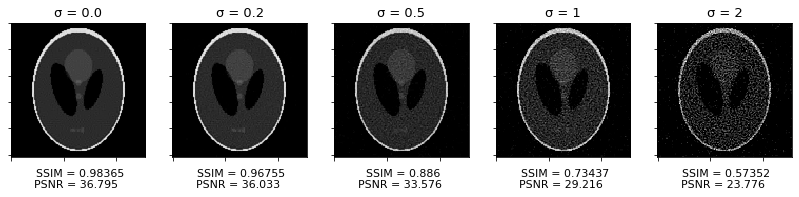

In [86]:
fig, ax = plt.subplots(1, 5, figsize=(14,10))
#[axi.set_axis_off() for axi in ax.ravel()]
for i, s in enumerate(sigma_range):
    im = recon_noise[i][0]
    ax[i].set_title('\u03C3 = {}'.format(s), fontsize=13)
    ax[i].imshow(im, cmap='gray')
    ax[i].set_xlabel('  SSIM = {0:.05g} \nPSNR = {1:.05g} '.format(compare_ssim(f_true, im.astype('float32')), compare_psnr(f_true, im.astype('float32'))), fontsize=11)
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
plt.savefig('./images_1/ista_noise_2.png', bbox_inches='tight')
plt.show()

#### Varying the number of angles

In [241]:
xrays_num = []
num_angles = [30, 45, 60]
recon_num = []
for num in num_angles:
    xray = Xray(f_true, angle_range=np.pi, num_proj=num, det_count=130, sigma=0.5, reg_type = 'zero')
    recon_num.append(ISTA(xray, alpha=1, mlambda=10**-3.8, maxIter = 600, tol=0.01))

8.907505
1.7709665
1.0309429
0.670863
0.4964373
0.41020748
0.36238196
0.32992277
0.30512252
0.2839153
0.26589936
0.24952775
0.23463754
0.22087099
0.20815364
0.19684313
0.18690899
0.17772488
0.16914703
0.16102447
0.15370563
0.14685158
0.14045869
0.13464104
0.12902349
0.12373479
0.118953526
0.114500836
0.110196054
0.10640303
0.10243736
0.098650455
0.09528491
0.09222159
0.089126684
0.08622088
0.083339
0.080840215
0.07853051
0.07624134
0.0740208
0.07199741
0.07010286
0.06821334
0.066276014
0.06447362
0.06286406
0.06118731
0.05967917
0.058165178
0.056656104
0.055256367
0.053988036
0.052723847
0.0515145
0.050450616
0.049334593
0.04829907
0.047215875
0.04624181
0.045355517
0.04444147
0.043590534
0.04271563
0.04192527
0.041147877
0.040338162
0.03956458
0.03880909
0.03812428
0.03751117
0.03682945
0.0362239
0.03567417
0.035074867
0.03453337
0.033989593
0.03343332
0.032927323
0.032458793
0.031957265
0.031493668
0.031045692
0.030597204
0.030160185
0.029698893
0.029278303
0.028896928
0.028538417
0.

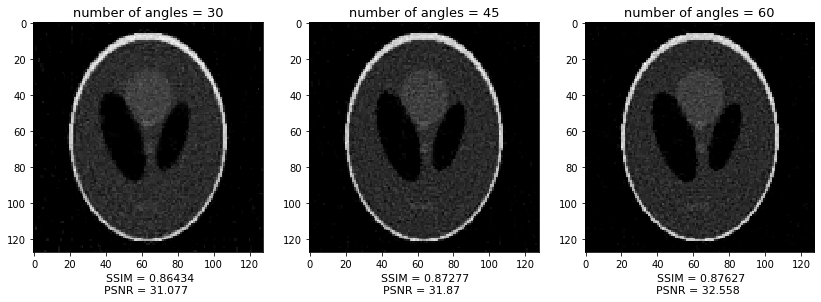

In [243]:
fig, ax = plt.subplots(1, 3, figsize=(14,10))
for i, s in enumerate(num_angles):
    im = recon_num[i][0]
    ax[i].set_title('number of angles = {}'.format(s), fontsize=13)
    ax[i].imshow(im, cmap='gray')
    ax[i].set_xlabel('  SSIM = {0:.05g} \nPSNR = {1:.05g} '.format(compare_ssim(f_true, im.astype('float32')), compare_psnr(f_true, im.astype('float32'))), fontsize=11)
plt.savefig('./images_1/ista_num.png', bbox_inches='tight')
plt.show()

#### Varying range of angles

In [89]:
xrays_ang = []
angle_range = [np.pi/2, 3*np.pi/4, np.pi]
recon_ang = []
for angle in angle_range:
    xray = Xray(f_true, angle_range=angle, num_proj=90, det_count=130, sigma=0.5, reg_type = 'zero')
    recon_ang.append(ISTA(xray, alpha=1, mlambda=10**-3.8, maxIter = 600, tol=0.01))

12.359124
2.7336283
1.5656741
1.1058941
0.8492256
0.6806925
0.5619004
0.47363657
0.40568474
0.35101512
0.3074979
0.27193558
0.24219023
0.21701671
0.19504482
0.1769762
0.16162604
0.14838131
0.13655888
0.12671189
0.1181259
0.11055246
0.10399025
0.09800461
0.0925728
0.08770598
0.08349698
0.07975671
0.07616337
0.07279746
0.06975707
0.06706346
0.06459958
0.062349264
0.06031858
0.05823366
0.056289434
0.054591063
0.0528806
0.05146135
0.05009125
0.048645057
0.047404118
0.046393767
0.04538325
0.044450793
0.043552723
0.042724703
0.041930586
0.04108235
0.04037202
0.03969871
0.039043427
0.038362745
0.037724387
0.03717144
0.03657389
0.03601035
0.035456017
0.03496239
0.03450306
0.034062903
0.033666506
0.033198074
0.032770656
0.032406643
0.031965096
0.031598154
0.031286933
0.030969225
0.030608272
0.030293453
0.0299854
0.029704275
0.02942725
0.029178284
0.02892657
0.028635168
0.02836229
0.028132452
0.027887233
0.027585007
0.027303874
0.027050266
0.026812665
0.026558397
0.026316598
0.026033929
0.025788

0.010392183
0.010342661
0.010286146
0.010231698
0.010175483
0.010122298
0.010074642
0.0100293355
0.009982811


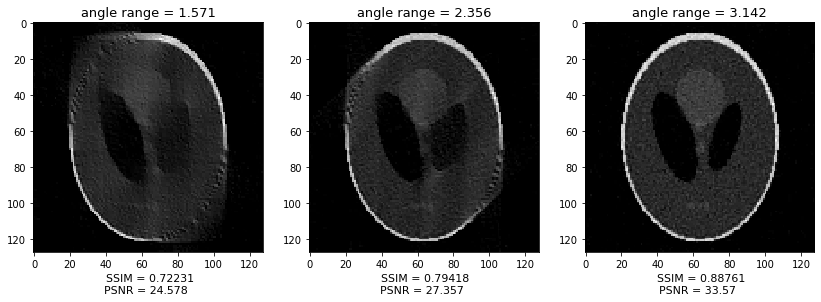

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(14,10))
for i, s in enumerate(angle_range):
    im = recon_ang[i][0]
    ax[i].set_title('angle range = {0:.3f}'.format(s), fontsize=13)
    ax[i].imshow(im, cmap='gray')
    ax[i].set_xlabel('  SSIM = {0:.05g} \nPSNR = {1:.05g} '.format(compare_ssim(f_true, im.astype('float32')), compare_psnr(f_true, im.astype('float32'))), fontsize=11)
plt.savefig('./images_1/ista_ang.png', bbox_inches='tight')
plt.show()

# Part B - Learned Reconstructon

####  We need a training set; for that write a function that creates a phantoms of random ellipses, for instance between 5 and 20 ellipses that can overlap (remember to normalise all phantoms to [0,1])

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import optim
from tqdm import tqdm 
from skimage.draw import ellipse

In [4]:
def generate_phantom(dim):
    
    def generate_ellipse(dim):
        
        temp_img = np.zeros((dim, dim), dtype=np.double)
        
        r, c = np.random.randint(low=dim//8, high=dim - dim//8, size=2)
        r_radius, c_radius = np.random.randint(low=4, high=dim//4, size=2)
        
        #r, c = np.random.randint(low=0, high=dim, size=2)
        #r_radius, c_radius = np.random.randint(low=2, high=dim//2, size=2)
        
        rr, cc = ellipse(r, c, r_radius, c_radius, (dim, dim))
        temp_img[rr, cc] = np.random.uniform(0.3,1)
        
        return temp_img
    
    img = np.zeros((dim, dim), dtype=np.double)
    
    for _ in range(np.random.randint(5, 21)):
        img += generate_ellipse(dim)
        
    return (img/np.max(img))

In [5]:
# Training and generation parameters
dim = 128
NUM = 1200
sigma = 0.5
train_size = 3*NUM//4
num_angles = 30
det_count = 130

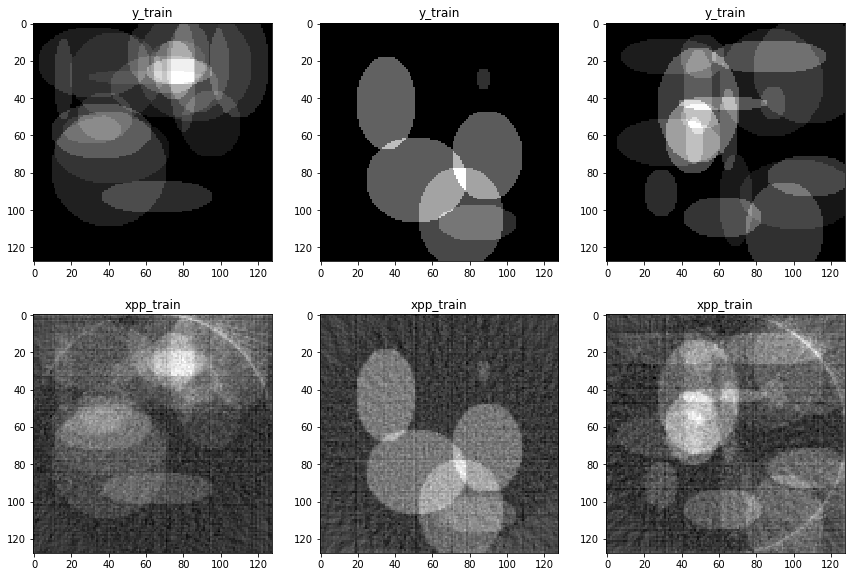

In [6]:
# Ground truth training data
data = np.zeros(shape=(NUM, dim**2))
# Sinogram data
data_mb = np.zeros((NUM, num_angles*det_count))
# FBP reconstructions
data_pp = np.zeros((NUM, dim*dim))

for i in range(NUM):
    img = generate_phantom(dim)
    data[i] = img.ravel()
    
for i in range(NUM):
    img = data[i].reshape((dim,dim))
    xray = Xray(img, np.pi, num_angles, det_count, sigma, 'zero')
    data_mb[i] = xray.getG().ravel()
    data_mb[i] = data_mb[i]/np.max(data_mb[i]) 
    data_pp[i] = xray.get_fbp().ravel()
    data_pp[i] = data_pp[i]/np.max(data_pp[i])
    
# Display some examples
fig, ax = plt.subplots(2, 3, figsize=(12,12))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=-0.45)
for i in range(3):

    ax[0, i].imshow(data[i+20].reshape((dim,dim)), cmap='gray')
    ax[0, i].set_title('y_train')
    
    ax[1, i].imshow(data_pp[i+20].reshape((dim,dim)), cmap='gray')
    ax[1, i].set_title('xpp_train')

plt.savefig('./images_1/at_data_examples', bbox_inches='tight')
plt.show()

In [7]:
### Separate in training/validation sets and convert to torch tensors
x_train, y_train, g_train = data_pp[:train_size], data[:train_size], data_mb[:train_size]
x_valid, y_valid, g_valid = data_pp[train_size:], data[train_size:], data_mb[train_size:]

x_train, y_train, g_train, x_valid, y_valid, g_valid = map(
    torch.tensor, (x_train, y_train, g_train, x_valid, y_valid, g_valid)
)

In [8]:
def generate_phantom_sets(NUM):
    data = np.zeros(shape=(NUM, dim**2))
    # Sinogram data
    data_mb = np.zeros((NUM, num_angles*det_count))
    # FBP reconstructions
    data_pp = np.zeros((NUM, dim*dim))

    for i in range(NUM):
        img = generate_phantom(dim)
        data[i] = img.ravel()
    
    for i in range(NUM):
        img = data[i].reshape((dim,dim))
        xray = Xray(img, np.pi, num_angles, det_count, sigma, 'zero')
        data_mb[i] = xray.getG().ravel()
        data_pp[i] = xray.get_fbp().ravel()
        
    x_train, y_train, g_train = data_pp, data, data_mb

    x_train, y_train, g_train = map(
        torch.tensor, (x_train, y_train, g_train)
    )
    
    train_ds = TensorDataset(x_train.to(dev), y_train.to(dev), g_train.to(dev))
    train_dl = DataLoader(train_ds, batch_size=20)
    return train_dl

# Shepp-Logan phantom as test image
f_true = resize(np.load('SlPhan.npy'), (dim,dim))
xray = Xray(f_true, np.pi, num_angles, det_count, sigma, 'zero')
g = xray.getG().ravel()
f_fbp = xray.get_fbp().ravel()

print(np.linalg.norm(f_true.ravel() - f_fbp)**2/dim**2)

dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

f_true, g, f_fbp = map(torch.DoubleTensor, (f_true, g, f_fbp))
f_true, g, f_fbp = f_true.to(dev), g.to(dev), f_fbp.to(dev)

0.017311925753812605
cuda


In [9]:
# Get discrete Radon transform and convert to tensor
A = torch.tensor(xray.get_A_matrix())

astra.data2d.clear()
astra.algorithm.clear()
astra.projector.clear()

### Block for Post-Processing Network

In [10]:
class Block(nn.Module):
    
    def __init__(self, out_channels):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(1, out_channels, kernel_size=3, padding=1, padding_mode='same')
        self.conv2 = nn.Conv2d(out_channels, 1, kernel_size=3, padding=1, padding_mode='same')
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = x.view(-1, 1, dim, dim)
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = out + identity
        out = self.relu(out)
        return out  

### Block for Model-based network

In [11]:
class ModelBlock2(nn.Module):
    
    def __init__(self, out_channels):
        super(ModelBlock2, self).__init__()
        self.conv1 = nn.Conv2d(2, out_channels, kernel_size=3, padding=1, padding_mode='same')
        self.conv2 = nn.Conv2d(out_channels, 2, kernel_size=3, padding=1, padding_mode='same')
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x, y):
        
        xt = x.view(x.size(0), -1)
        # Data gradient term
        t1 = torch.transpose(A, 1, 0)
        t2 = torch.transpose(xt, 1, 0)
        t3 = torch.mm(A, t2) - torch.transpose(y, 1, 0)
        t4 = torch.mm(t1, t3)
        t4 = t4/t4.max(t4)
        gradx = t4.view(-1,1,dim,dim)
        
        # Stack identity and data gradient
        x = x.view(-1, 1, dim, dim)
        identity = x
        
        update = torch.cat((x, gradx), 1)
        update = self.relu(self.conv1(update))
        update = self.conv2(update)
        x = self.relu(identity + update[:,0:1,:,:])
        
        return x

### ResNet for post-processing and model-based 'blocks'

In [12]:
class ResNet(nn.Module):
    
    def __init__(self, block, blocks, out_channels):
        
        super(ResNet, self).__init__()
        self._blocks = blocks
        self._layers = nn.ModuleList([block(out_channels) for _ in range(blocks)])
        
    def forward(self, x, y=None, num_layers=None):
        
        if num_layers is None:
            num_layers = len(self._layers)
                
        xtemp = x.view(-1, 1, dim, dim)
        for l in range(num_layers):
            layer = self._layers[l]
            if y is not None:
                x = layer(x, y)
            else:
                x = layer(x)
            
        return x

### Network fitting and training functions 
Adapted from https://pytorch.org/tutorials/beginner/nn_tutorial.html

In [13]:
# Compute loss for a single batch and backprop if training.
def loss_batch(model, loss_func, xb, yb, gb, mtype = 'post-process', opt=None):
    # Get model prediction and compute loss
    if(mtype == 'post-process'):
        # post-processing model only requires single input
        pred = model(xb)
    else:
        #gb.requires_grad = False
        #gb.detach()
        pred = model(xb, gb)
  
    pred = pred.view(pred.size(0), -1)
    loss = loss_func(pred, yb)

    if opt is not None:
        # Backpropagate
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit_model(epochs, model, loss_func, opt, mtype, train_dl, valid_dl):
    counter = 0
    phantoms = []
    for epoch in range(epochs):

        model.train()
        sum_loss = np.zeros(2)
        for xb, yb, gb in train_dl:
            train_loss, num = loss_batch(model, loss_func, xb, yb, gb, mtype, opt)
            if(counter%50==0):
                print('current training loss: {}'.format(train_loss))
            counter += 1
        model.eval()
        with torch.no_grad():
            
            phantoms.append(test_model(mtype, model))
            losses, nums = zip(
                    *[loss_batch(model, loss_func, xb, yb, gb, mtype) for xb, yb, gb in valid_dl]
                )
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print('epoch:', epoch, 'val loss: ', val_loss)
    return phantoms

# Test model on the Shepp-Logan Phantom
def test_model(mtype, model):
    if(mtype == 'post-process'):
        f_rec = model.forward(f_fbp.unsqueeze(0))[0][0].detach().cpu().numpy()
    else:
        f_rec = model.forward(f_fbp.unsqueeze(0), g.unsqueeze(0))[0][0].detach().cpu().numpy()
    
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(f_rec)
    ax[1].imshow(f_true.cpu().numpy())
    ax[0].set_xlabel(np.linalg.norm(f_true.cpu().numpy().ravel() - f_rec.ravel())**2/dim**2)
    plt.show()
    print('SSIM ', compare_ssim(f_true.cpu().numpy(), f_rec))
    print('PSNR ', compare_psnr(f_true.cpu().numpy(), f_rec))
    
    return f_rec

#### Train a post-processing network architectures for approach i.). Here we can use a simple image-to-image ResNet architecture. This architecture consists of a repeated residual block that consists of 2 convolutional layers and an additive residual connection. The residual block is then repeated for a set amount, e.g. between n = 5,...,10. (This could be considered as n iterations)

In [91]:
# Dataset wrappers
train_ds = TensorDataset(x_train.to(dev), y_train.to(dev), g_train.to(dev))
valid_ds = TensorDataset(x_valid.to(dev), y_valid.to(dev), g_valid.to(dev))
train_dl = DataLoader(train_ds, batch_size=16)
valid_dl = DataLoader(valid_ds, batch_size=2*16)

A = A.to(dev)
loss_func = torch.nn.functional.mse_loss
epochs = 15

# Post-processing
model_pp = ResNet(Block, blocks = 8, out_channels = 32).double().to(dev)
opt = optim.Adam(model_pp.parameters())

current training loss: 0.06279705597352048
current training loss: 0.004896090446598449


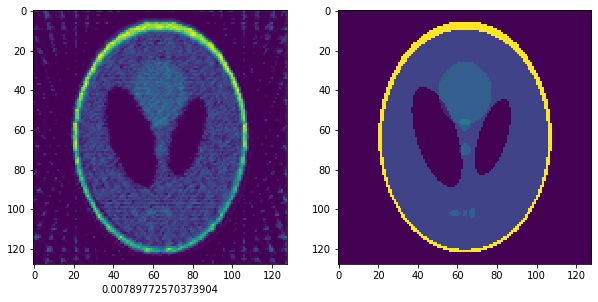

SSIM  0.6530558971174127
PSNR  27.045579451663823
epoch: 0 val loss:  0.004776523913219877
current training loss: 0.004292366647724378


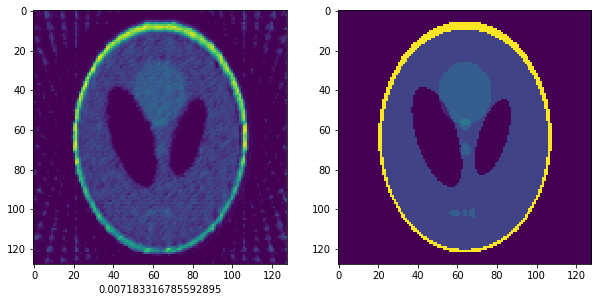

SSIM  0.7230183165874888
PSNR  27.457349720057195
epoch: 1 val loss:  0.003819524806624064
current training loss: 0.003470475978199862


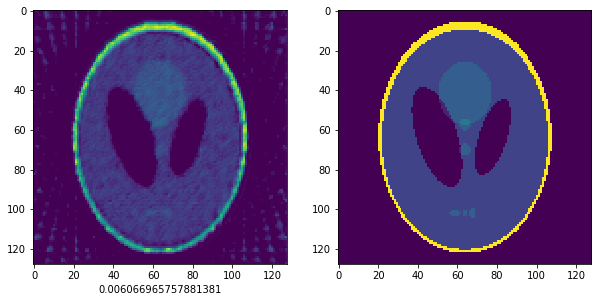

SSIM  0.7829945312341843
PSNR  28.19088447546784
epoch: 2 val loss:  0.0037407304112017817
current training loss: 0.003102250675425502


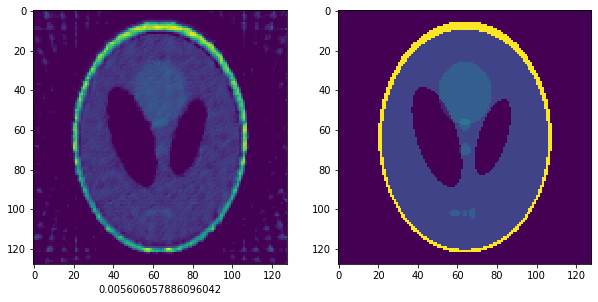

SSIM  0.8091732728645888
PSNR  28.5340241351513
epoch: 3 val loss:  0.00367031531241273
current training loss: 0.006231566364135068


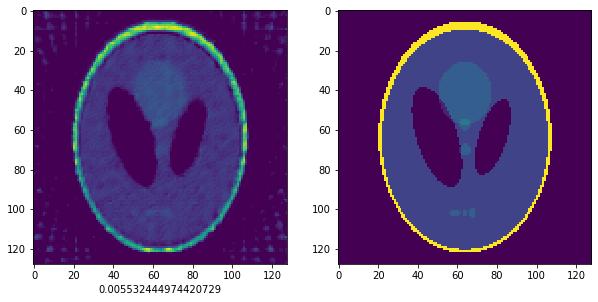

SSIM  0.822893005549579
PSNR  28.59142888190805
epoch: 4 val loss:  0.003430076062531262
current training loss: 0.004307501845962188


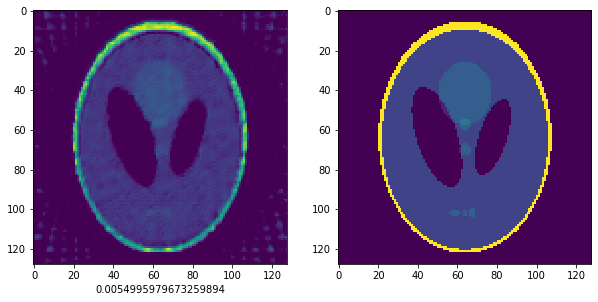

SSIM  0.8418344522052928
PSNR  28.617290485525466
epoch: 5 val loss:  0.0032785364621021103
current training loss: 0.0033505922196624474


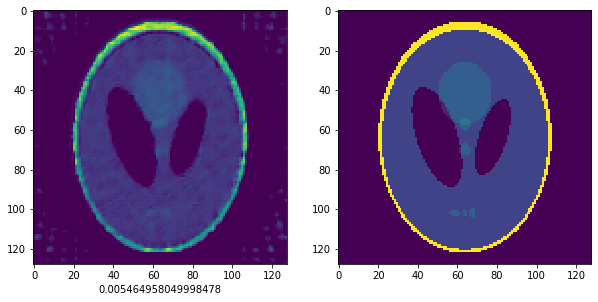

SSIM  0.8653895935938724
PSNR  28.64473158752049
epoch: 6 val loss:  0.0031445151576490263
current training loss: 0.004303788145243549
current training loss: 0.0026436912394891343


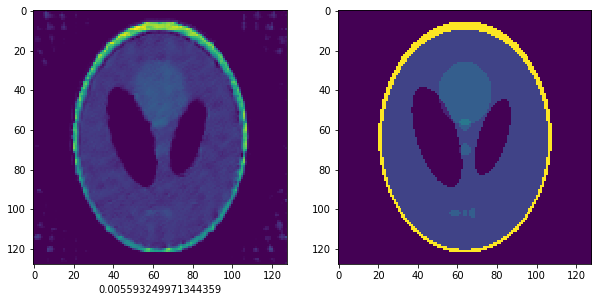

SSIM  0.8789528597675036
PSNR  28.54395762246529
epoch: 7 val loss:  0.003068681046643534
current training loss: 0.0036495530570108147


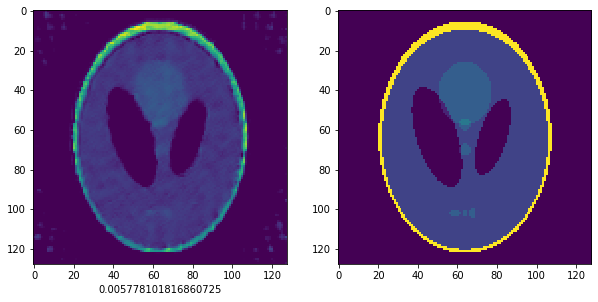

SSIM  0.8895926641687091
PSNR  28.402748009794962
epoch: 8 val loss:  0.0030294173568010574
current training loss: 0.0035065595578778292


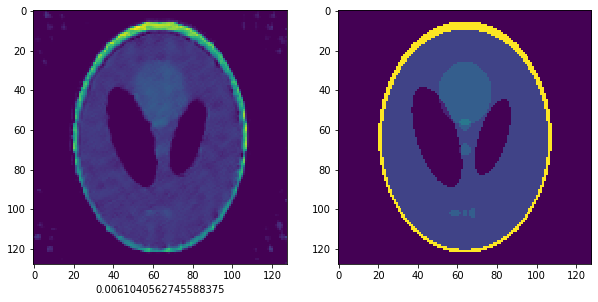

SSIM  0.8984788381331393
PSNR  28.164414625119186
epoch: 9 val loss:  0.0030383289508894764
current training loss: 0.0036725328778605864


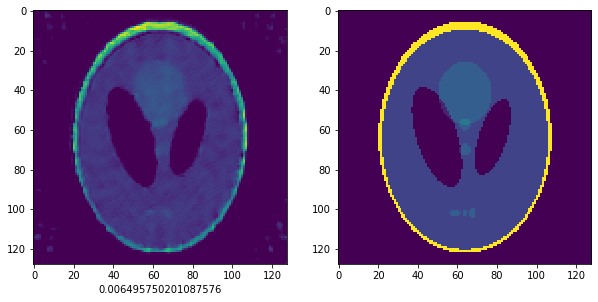

SSIM  0.899425777573058
PSNR  27.89430675891516
epoch: 10 val loss:  0.00304537969399728
current training loss: 0.003957382724186894


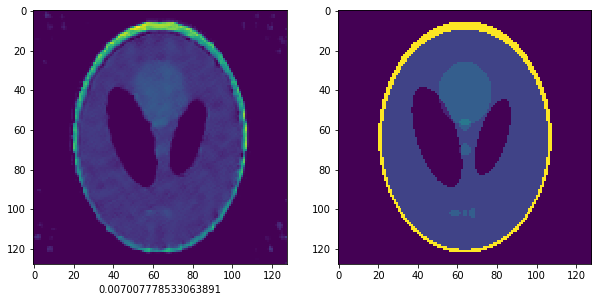

SSIM  0.8992849758683272
PSNR  27.56479622966465
epoch: 11 val loss:  0.0030768221828100005
current training loss: 0.005354245384651427


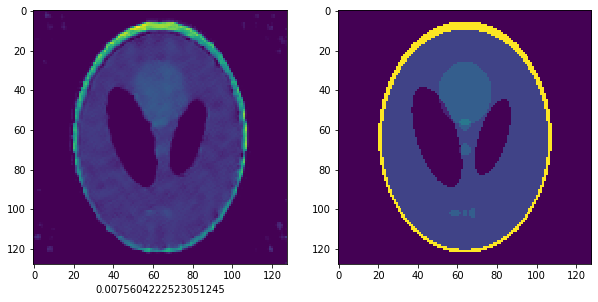

SSIM  0.8984753391986695
PSNR  27.235139396461978
epoch: 12 val loss:  0.003121293069968816
current training loss: 0.0028075809993888855


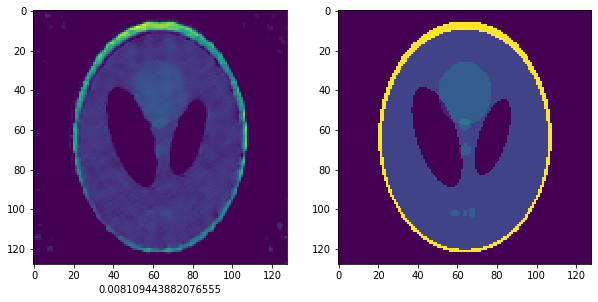

SSIM  0.8970307215882907
PSNR  26.930689185257492
epoch: 13 val loss:  0.003164946139094308
current training loss: 0.0032940769415436117
current training loss: 0.0027984060381862005


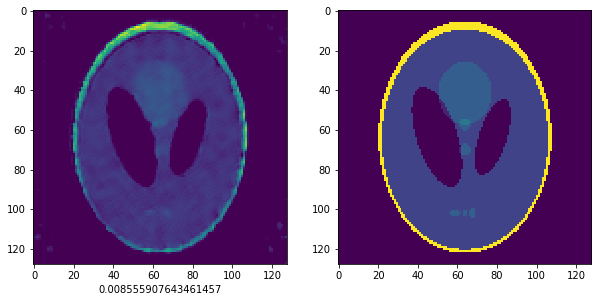

SSIM  0.896264973260011
PSNR  26.697939033844726
epoch: 14 val loss:  0.003198851431841178


In [92]:
phantom_pp = fit_model(epochs, model_pp, loss_func, opt, 'post-process', train_dl, valid_dl)

#### Train a model-based network: Treat each residual block as an iteration that outputs one updated reconstruction, then you need to compute the gradient of the data ﬁt AT(Af −g) before each residual block of your ResNet2. By concatenating current reconstruction and gradient you can use this as input to each residual block. This way you obtain a simple n iterations model-based network.

In [17]:
model_mb = ResNet(ModelBlock2, blocks = 6, out_channels = 32).double().to(dev)
opt = optim.Adam(model_mb.parameters())

current training loss: 0.0500456691493089
current training loss: 0.00383202732830778


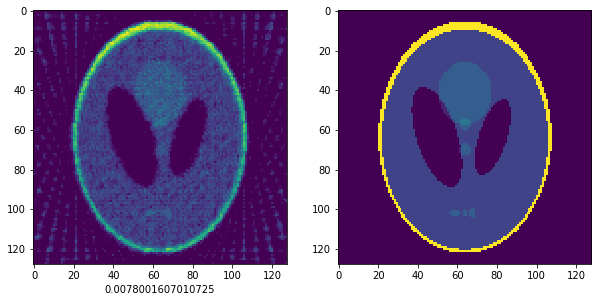

SSIM  0.6284910748804443
PSNR  27.099564410900353
epoch: 0 val loss:  0.004083185918924024
current training loss: 0.0040649129658938445


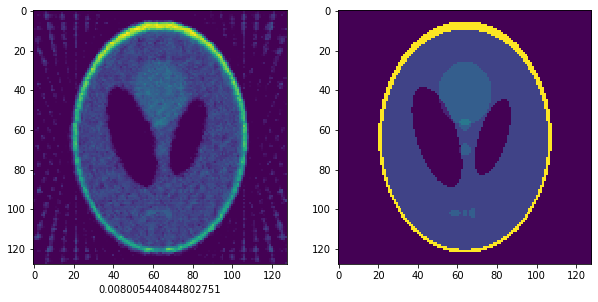

SSIM  0.6955783359924779
PSNR  26.986747386212336
epoch: 1 val loss:  0.003730612983644359
current training loss: 0.003326176640306926


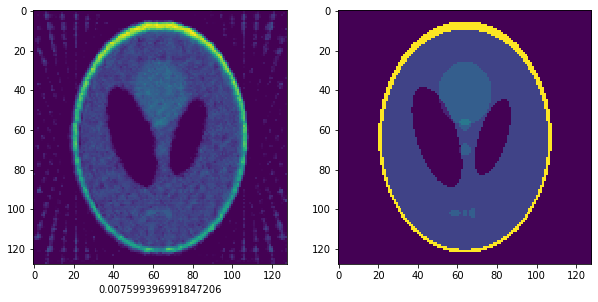

SSIM  0.7276296993836142
PSNR  27.21280858718641
epoch: 2 val loss:  0.0036409637488858224
current training loss: 0.003982990377918801


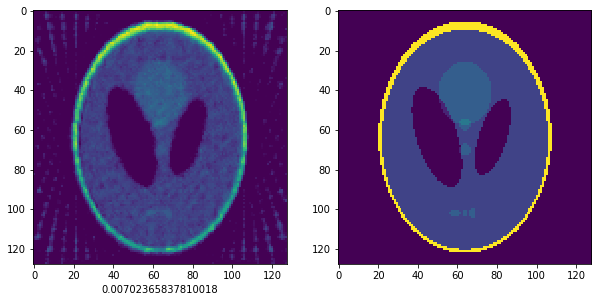

SSIM  0.7439324929338473
PSNR  27.554966114529886
epoch: 3 val loss:  0.0035599533782668794
current training loss: 0.006474880936681762


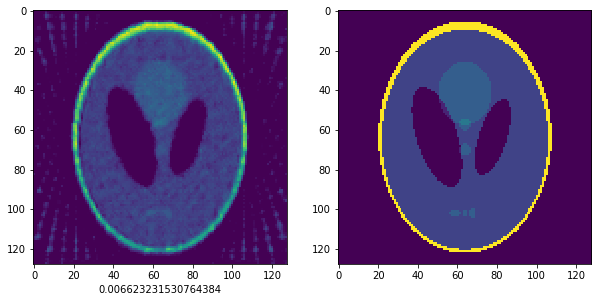

SSIM  0.7623895138506577
PSNR  27.80990054222216
epoch: 4 val loss:  0.003481027810680714
current training loss: 0.004318612479852086


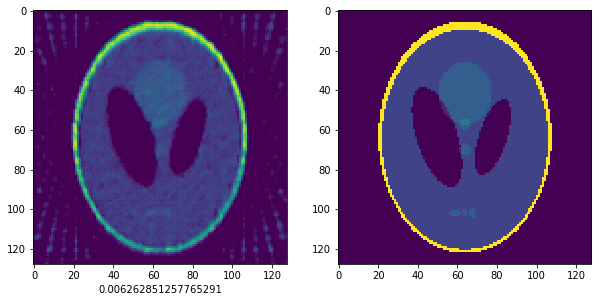

SSIM  0.7782396072673244
PSNR  28.05287893964648
epoch: 5 val loss:  0.0034145184867130384
current training loss: 0.003348577664983559


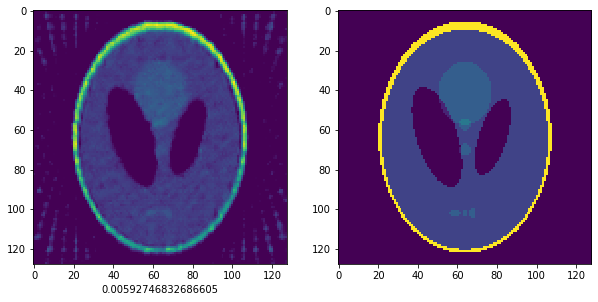

SSIM  0.7968238023171833
PSNR  28.29190749302629
epoch: 6 val loss:  0.003355504255467229
current training loss: 0.005276918619997242
current training loss: 0.0027703732584561085


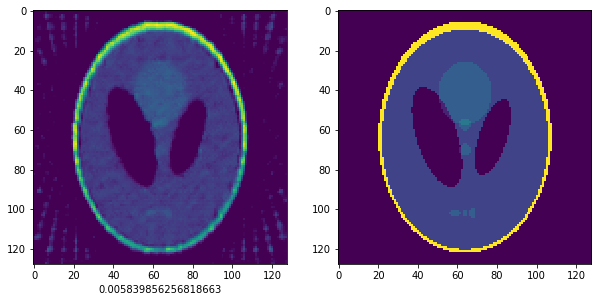

SSIM  0.8076295715577689
PSNR  28.356578338797327
epoch: 7 val loss:  0.003304856980054947
current training loss: 0.003832419604523303


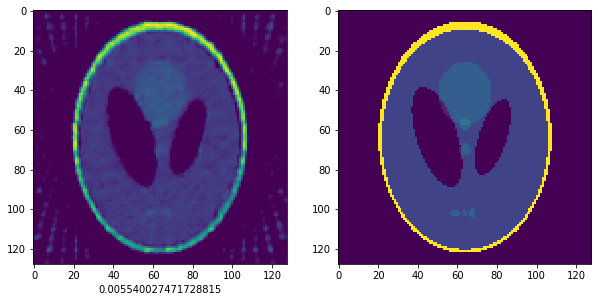

SSIM  0.8188927901788643
PSNR  28.58548073027213
epoch: 8 val loss:  0.0032338419562627906
current training loss: 0.003979828408759571


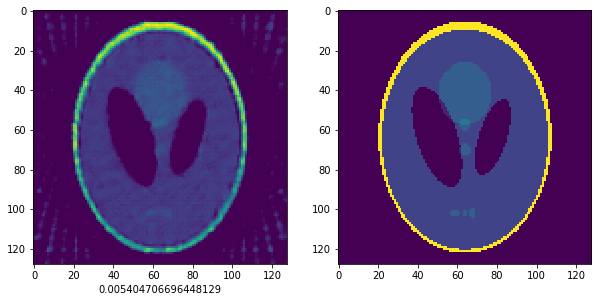

SSIM  0.8297857023815236
PSNR  28.692878607667332
epoch: 9 val loss:  0.0031742184092166783
current training loss: 0.003967780421271553


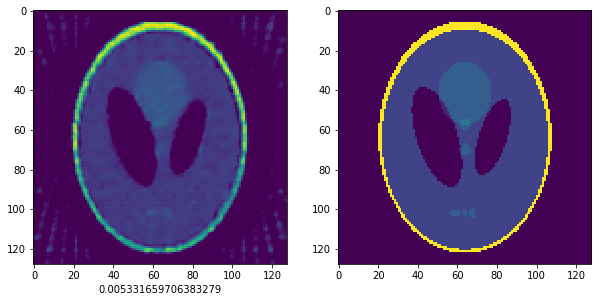

SSIM  0.8366835931577723
PSNR  28.751975685824178
epoch: 10 val loss:  0.0031297092461522362
current training loss: 0.004332057870415611


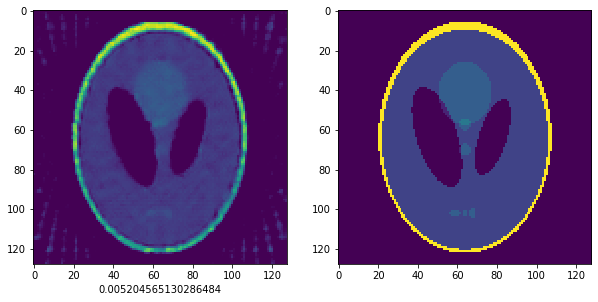

SSIM  0.8479459408453232
PSNR  28.8567554363067
epoch: 11 val loss:  0.003097880946480404
current training loss: 0.00591954563083872


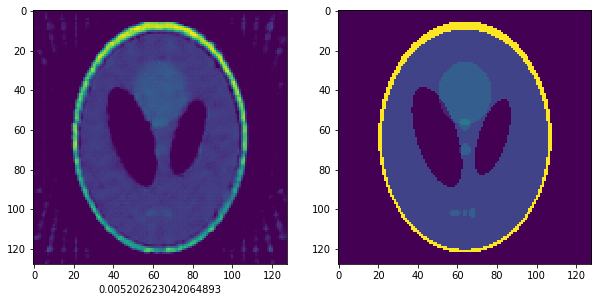

SSIM  0.8531616022794045
PSNR  28.858376312558434
epoch: 12 val loss:  0.003062286758248026
current training loss: 0.0030989566881207413


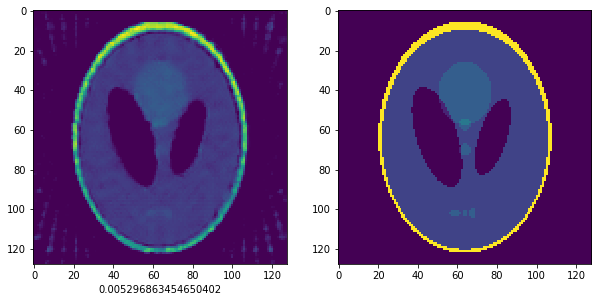

SSIM  0.8547317219819323
PSNR  28.78041213721079
epoch: 13 val loss:  0.003028114862499684
current training loss: 0.0034285625994868708
current training loss: 0.002839919921199548


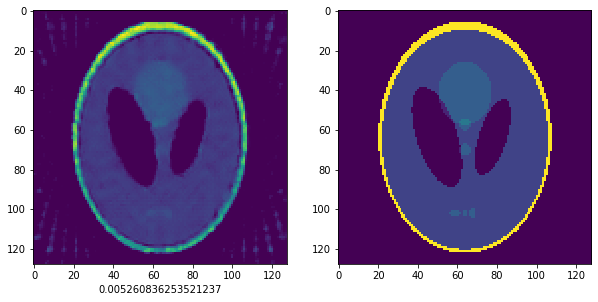

SSIM  0.85532568237581
PSNR  28.81005206979745
epoch: 14 val loss:  0.002998029661213555
current training loss: 0.002657891800333754


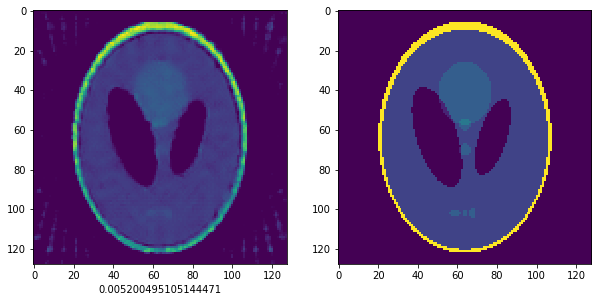

SSIM  0.8680654743151085
PSNR  28.860152993861462
epoch: 15 val loss:  0.0029779122696847043
current training loss: 0.0030948861183655993


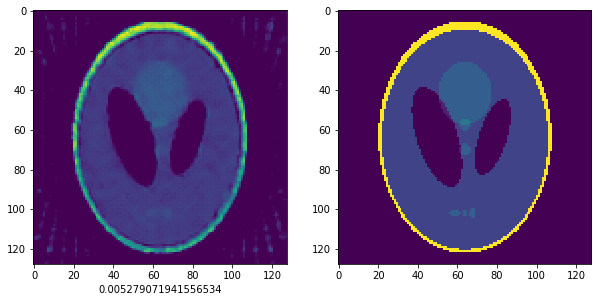

SSIM  0.87084355798624
PSNR  28.79502410856057
epoch: 16 val loss:  0.002952336249663533
current training loss: 0.00334441398528641


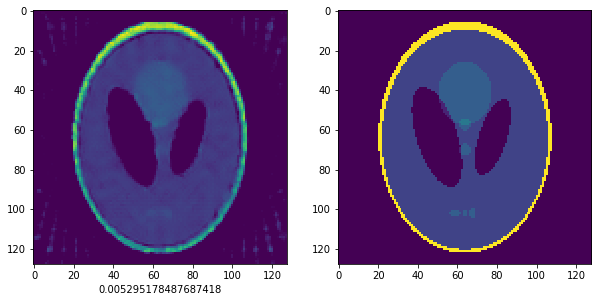

SSIM  0.8753667206706984
PSNR  28.78179387618873
epoch: 17 val loss:  0.002934341484781525
current training loss: 0.00420465579207201


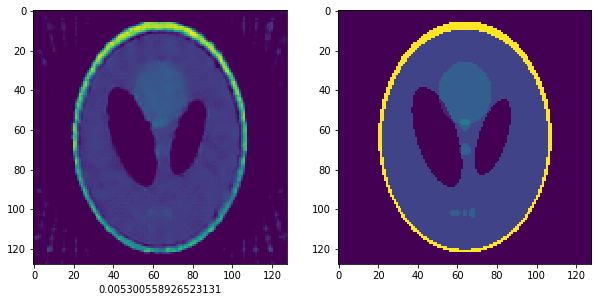

SSIM  0.8788028588573424
PSNR  28.777383243863554
epoch: 18 val loss:  0.0029176538282424933
current training loss: 0.002754377734151844


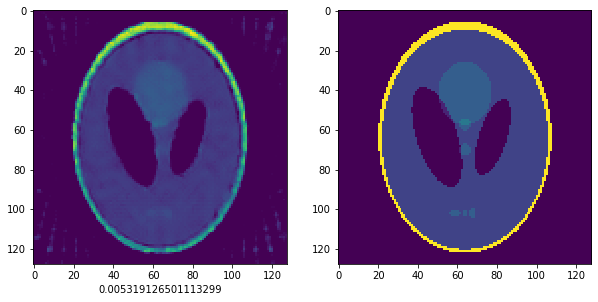

SSIM  0.8826399314500957
PSNR  28.762196723587323
epoch: 19 val loss:  0.0029031023856506194
current training loss: 0.0024849786450301904


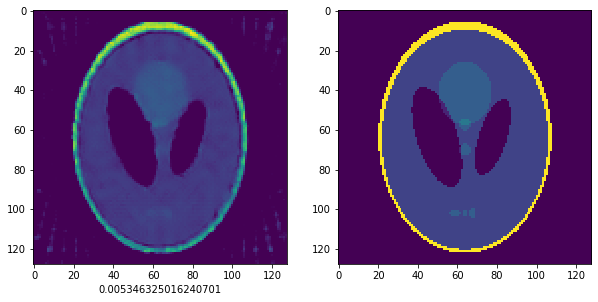

SSIM  0.8857207347690148
PSNR  28.74004634275707
epoch: 20 val loss:  0.002889510485939681
current training loss: 0.0026370460834956363
current training loss: 0.003304800551667577


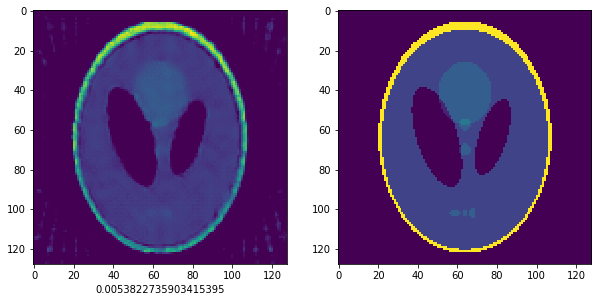

SSIM  0.8884418869349066
PSNR  28.710942213941514
epoch: 21 val loss:  0.0028771890950018966
current training loss: 0.0035295874260001664


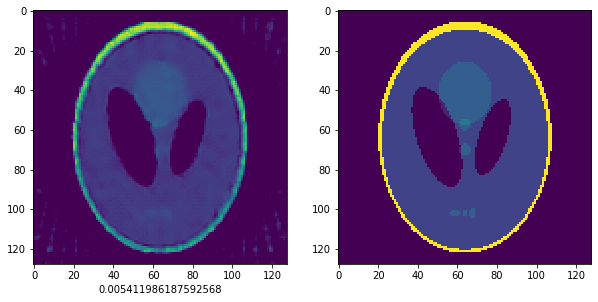

SSIM  0.8914321095342985
PSNR  28.687033118022264
epoch: 22 val loss:  0.0028653889891989033
current training loss: 0.0026708152264278045


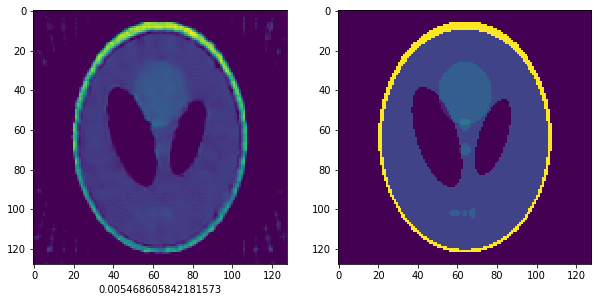

SSIM  0.893889108962759
PSNR  28.641833692395622
epoch: 23 val loss:  0.0028543950047916974
current training loss: 0.004839601803348941


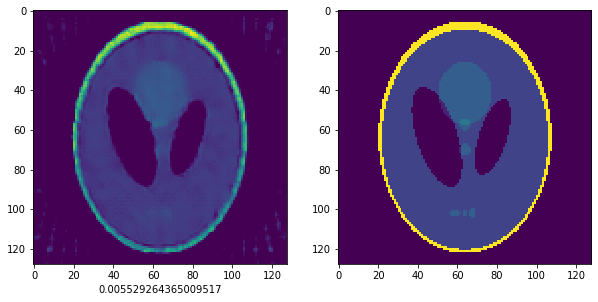

SSIM  0.8962480241424579
PSNR  28.593926364190516
epoch: 24 val loss:  0.00284414523326456
current training loss: 0.0029472223742896056


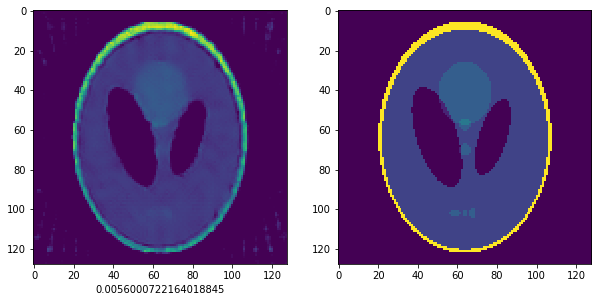

SSIM  0.8984008774352825
PSNR  28.538663637891517
epoch: 25 val loss:  0.0028329369150938326
current training loss: 0.0028057098790462117


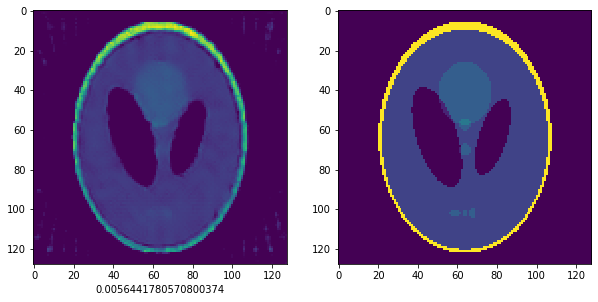

SSIM  0.9003307804811281
PSNR  28.504592853265244
epoch: 26 val loss:  0.0028224862336494625
current training loss: 0.0025316998256129444


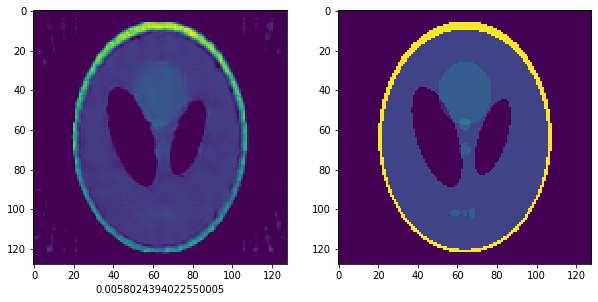

SSIM  0.9008139156369965
PSNR  28.384493777284334
epoch: 27 val loss:  0.002813550108121113
current training loss: 0.002433704928525632
current training loss: 0.002151115260858824


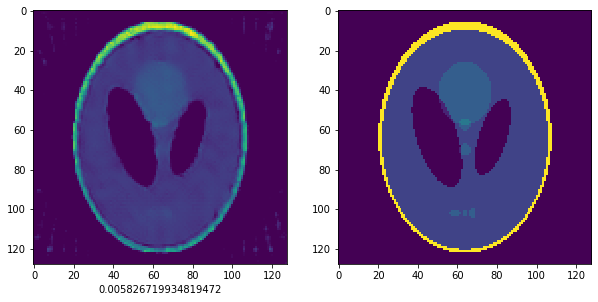

SSIM  0.9026362240630078
PSNR  28.36635847390131
epoch: 28 val loss:  0.0028047170308803616
current training loss: 0.003884643779170257


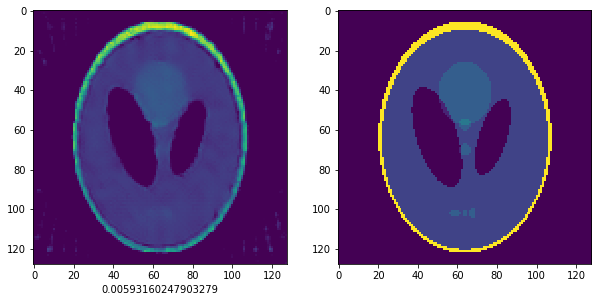

SSIM  0.9035360062032682
PSNR  28.288879533120355
epoch: 29 val loss:  0.002796798852232618


In [18]:
mb_recon = fit_model(epochs, model_mb, loss_func, opt, 'model-based', train_dl, valid_dl)

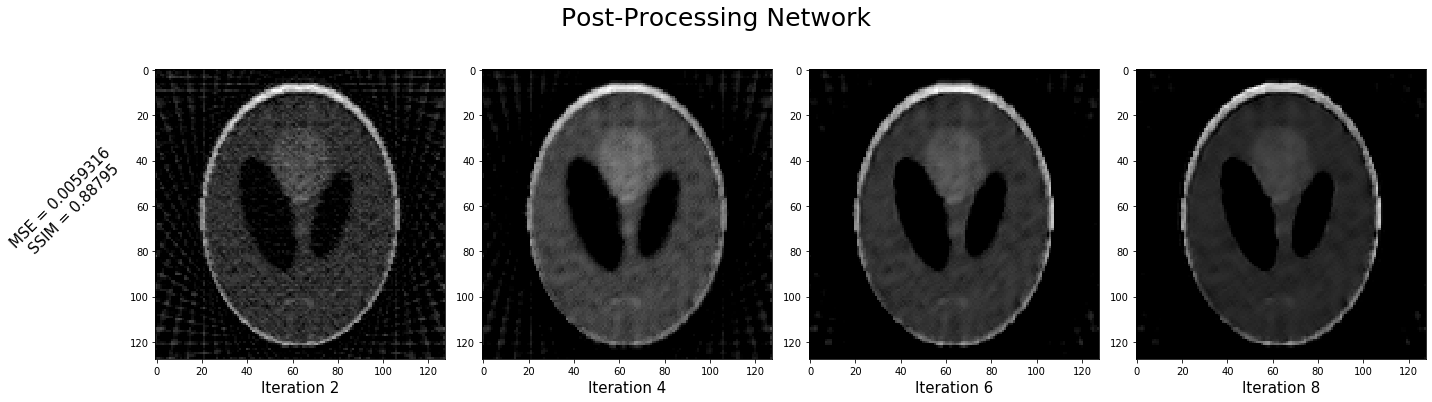

In [97]:
layers = [2,4,6,8]    
fig, ax = plt.subplots(1, 4, figsize=(20,6))

for i, l in enumerate(layers):
    f_rec_pp = model_pp.forward(f_fbp.unsqueeze(0), num_layers=l)[0][0].detach().cpu().numpy()
    #f_rec_mb = model_pp.forward(f_fbp.unsqueeze(0), g.unsqueeze(0), num_layers=l)[0][0].detach().cpu().numpy()
        
    #ax[0, i].imshow(f_rec_pp, cmap='gray')
    ax[i].imshow(f_rec_pp, cmap='gray')
    ax[i].set_xlabel('Iteration {0:.05g}'.format(l), fontsize = 15)

ax[0].set_ylabel('MSE = {0:.05g} \nSSIM = {1:.05g}'.format(
                        np.linalg.norm(f_true.cpu().numpy().ravel() - f_rec_mb.ravel())**2/dim**2
                        ,compare_ssim(f_true.cpu().numpy(), f_rec_mb)), fontsize = 15, rotation=45, labelpad=50)
fig.tight_layout()
fig.suptitle('Post-Processing Network', fontsize = 25) 

plt.savefig('./images_1/post_processing_recons.png', bbox_inches='tight')
plt.show()

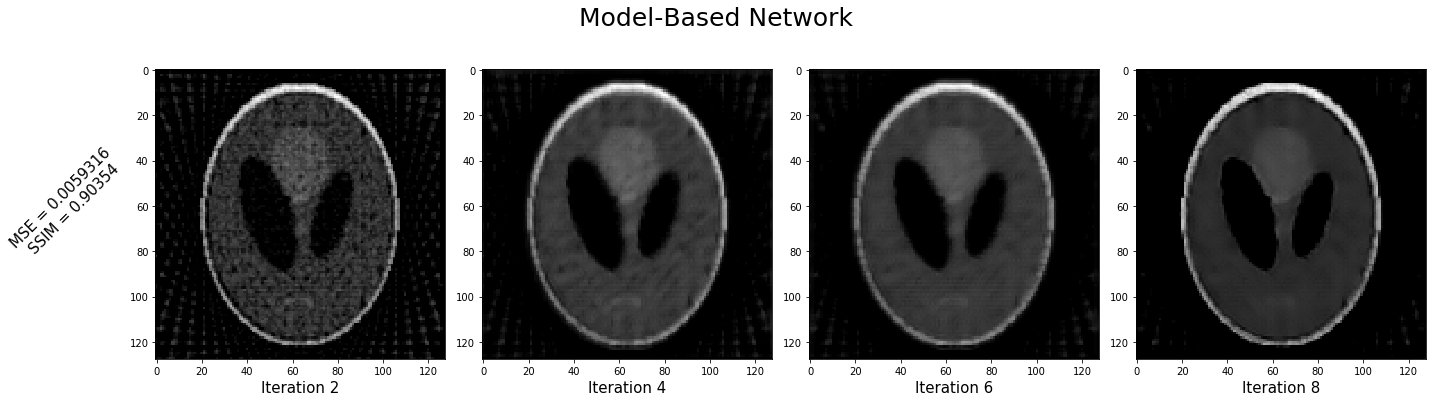

In [100]:
layers = [1,3,4,6]    
fig, ax = plt.subplots(1, 4, figsize=(20,6))

for i, l in enumerate(layers):
    #f_rec_pp = model_pp.forward(f_fbp.unsqueeze(0), num_layers=l)[0][0].detach().cpu().numpy()
    f_rec_mb = model_mb.forward(f_fbp.unsqueeze(0), g.unsqueeze(0), num_layers=l)[0][0].detach().cpu().numpy()
        
    #ax[0, i].imshow(f_rec_pp, cmap='gray')
    ax[i].imshow(f_rec_mb, cmap='gray')
    ax[i].set_xlabel('Iteration {0:.05g}'.format(2*i+2), fontsize = 15)

ax[0].set_ylabel('MSE = {0:.05g} \nSSIM = {1:.05g}'.format(
                        np.linalg.norm(f_true.cpu().numpy().ravel() - f_rec_mb.ravel())**2/dim**2
                        ,compare_ssim(f_true.cpu().numpy(), f_rec_mb)), fontsize = 15, rotation=45, labelpad=50)
fig.tight_layout()
fig.suptitle('Model-Based Network', fontsize = 25) 

plt.savefig('./images_1/learning_recons_.png', bbox_inches='tight')
plt.show()

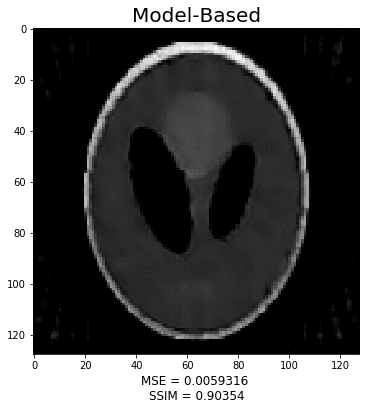

In [119]:
plt.figure(figsize=(6,6))
plt.imshow(f_rec_mb, cmap = 'gray')
plt.xlabel('MSE = {0:.05g} \nSSIM = {1:.05g}'.format(
                        np.linalg.norm(f_true.cpu().numpy().ravel() - f_rec_mb.ravel())**2/dim**2
                        ,compare_ssim(f_true.cpu().numpy(), f_rec_mb)), fontsize = 12)
plt.title('Model-Based', fontsize = 20)
plt.savefig('./images_1/learning_recons_final.png', bbox_inches='tight')
plt.show()

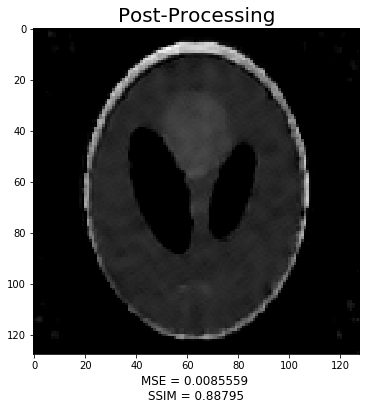

In [118]:
plt.figure(figsize=(6,6))
plt.imshow(f_rec_pp, cmap = 'gray')
plt.xlabel('MSE = {0:.05g} \nSSIM = {1:.05g}'.format(
                        np.linalg.norm(f_true.cpu().numpy().ravel() - f_rec_pp.ravel())**2/dim**2
                        ,compare_ssim(f_true.cpu().numpy(), f_rec_pp)), fontsize = 12)
plt.title('Post-Processing', fontsize = 20)
plt.savefig('./images_1/post_processing_final.png', bbox_inches='tight')
plt.show()